In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/13

In [ ]:
# Standard library imports
from os.path import join
from collections import OrderedDict
from array import array

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import random

# Type hinting imports
from typing import Callable, Dict, List, Optional, Tuple, Any  # For type annotations

# Google Colab specific imports
from google.colab import drive
drive.mount('/content/drive')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torchvision
import torchvision.transforms as transforms

# torchvision imports
import torchvision.transforms as transforms  # For image transformations

# Flower (Federated Learning) imports
import flwr as fl  # Core Flower framework
from flwr.common import (  # Common Flower types and functions
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager  # For managing clients on server-side
from flwr.server.client_proxy import ClientProxy  # For server-side client proxy management

# Device setup
DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)


Mounted at /content/drive
Training on cpu using PyTorch 2.3.1+cu121 and Flower 1.10.0


# Load Data

In [ ]:
input_path = '/content/drive/MyDrive/Colab Notebooks/data'

test_filepath = join(input_path, 'fashion-mnist/fashion-mnist_test.csv')
train_filepath = join(input_path, 'fashion-mnist/fashion-mnist_train.csv')

test_filepath, train_filepath

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('/content/drive/MyDrive/Colab Notebooks/data/fashion-mnist/fashion-mnist_test.csv',
 '/content/drive/MyDrive/Colab Notebooks/data/fashion-mnist/fashion-mnist_train.csv')

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.int64)

class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X_data[idx], dtype=torch.float32)
        y = torch.tensor(self.y_data[idx], dtype=torch.long)
        return x, y

class MnistDataloader(object):
    def __init__(self, training_filepath, testing_filepath):
        self.training_filepath = training_filepath
        self.testing_filepath = testing_filepath
        self.batch_size = 32

        # Load and save the train and test loaders
        (X_train, y_train), (X_test, y_test) = self.load_data()
        # self.train_loader = self.create_data_loader(X_train, y_train)
        self.test_loader = self.create_data_loader(X_test, y_test, shuffle=False)

    def read_images_labels(self, filepath):
        data = pd.read_csv(filepath)
        labels = torch.tensor(data.iloc[:, 0].values, dtype=torch.long)
        images = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float).view(-1, 28, 28)
        return images, labels

    def load_data(self):
        X_train, y_train = self.read_images_labels(self.training_filepath)
        X_test, y_test = self.read_images_labels(self.testing_filepath)

        X_train, X_test = np.expand_dims(np.array(X_train), axis=1), np.expand_dims(np.array(X_test), axis=1)
        y_train, y_test = np.array(y_train), np.array(y_test)

        return (X_train, y_train), (X_test, y_test)

    def create_data_loader(self, images, labels, shuffle=True):
        dataset = CustomDataset(images, labels)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

In [ ]:
test_dataloader = MnistDataloader(test_filepath, train_filepath)

(test_X_train, test_y_train), (test_X_test, test_y_test) = test_dataloader.load_data()

In [ ]:
test_X_train[0]

array([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,   8.,   0.,
           0.,  34.,  29.,   7.,   0.,  11.,  24.,   0.,   0.,   3.,
           3.,   1.,   0.,   1.,   1.,   0.,   0.,   0.],
        [  0.,   0.,   4.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,  44.,  88.,  99., 122., 123.,  80.,   0.,   0.,   0.,
           0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   1.,   2.,   0.,   0.,   0.,   3.,  46., 174.,
         249.,  67.,   0.,  94., 210.,  61.,  14., 212., 157.,  37.,
           0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.],
        [  0.,   0.,   2.,   2.,   0.,  23., 168., 206., 242., 239.,
         238., 214., 125.,  61., 113.,  74., 133., 236., 238., 236.,
         203., 184.,  20.,   0.,   1.,   0.,   0.,   0.],
        [  0.,   0.,   1.,   0.,   0., 175., 245., 223., 207., 205.,
         206., 216., 255., 237., 251., 232., 223., 212., 200., 205.,
         216., 249., 173.,   0.,   0.,   2.,   0.,   0.],
        [  0.,   0.,

# Generate balanced data and unbalanced data

In [ ]:
def split_dataset_balanced(num_clients, X_train, y_train, X_test, y_test, batch_size=32):
    """
    Splits the given training and testing data into balanced subsets for a given number of clients
    and returns lists of DataLoader objects.
    """
    # Create datasets
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    def create_balanced_subsets(dataset, num_clients):

        # Group indices by label
        label_to_indices = defaultdict(list)
        for idx in range(len(dataset)):
                _, label = dataset[idx]
                label_to_indices[label.item()].append(idx)

        # Find the minimum number of samples for any label
        min_label_count = min(len(indices) for indices in label_to_indices.values())

        # Determine the number of samples per client per label
        samples_per_client_per_label = min_label_count // num_clients

        # Create an array to hold indices for each client
        client_indices = [[] for _ in range(num_clients)]

        # Distribute indices for each label to each client
        for label, indices in label_to_indices.items():
            np.random.shuffle(indices)  # Shuffle indices to ensure randomness
            for i in range(num_clients):
                start_idx = i * samples_per_client_per_label
                end_idx = (i + 1) * samples_per_client_per_label
                client_indices[i].extend(indices[start_idx:end_idx])

        # Create subsets for each client
        subsets = [Subset(dataset, indices) for indices in client_indices]

        return subsets

    # Create balanced subsets for train and test datasets
    train_subsets = create_balanced_subsets(train_dataset, num_clients)
    test_subsets = create_balanced_subsets(test_dataset, num_clients)

    # Create DataLoaders for each subset
    train_loaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in train_subsets]
    test_loaders = [DataLoader(subset, batch_size=batch_size, shuffle=False) for subset in test_subsets]

    return train_loaders, test_loaders

def create_unbalanced_loaders(train_loaders, test_loaders, label_counts, alpha):
    """
    Converts balanced train and test DataLoader objects into unbalanced DataLoader objects by redistributing the samples.

    """

    def create_unbalanced_loader(loader, p):
        label_to_indices = defaultdict(list)
        dataset = loader.dataset

        # Build the mapping from labels to indices
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            label_to_indices[label.item()].append(idx)

        subset_indices = []
        for label, indices_list in label_to_indices.items():
            prob = p[label]
            for idx in indices_list:
                if np.random.rand() < prob:
                    subset_indices.append(idx)

        subset_dataset = Subset(dataset, subset_indices)
        subset_loader = DataLoader(subset_dataset, batch_size=loader.batch_size, shuffle=True)

        return subset_loader

    unbalanced_train_loaders = []
    unbalanced_test_loaders = []
    for i in range(len(train_loaders)):

        train_loader = train_loaders[i]
        test_loader = test_loaders[i]

        # Generate Dirichlet distribution to get probabilities
        p = np.random.dirichlet([alpha] * label_counts)

        # Normalize probabilities
        p /= np.max(p)

        unbalanced_train_loaders.append(create_unbalanced_loader(train_loader, p))
        unbalanced_test_loaders.append(create_unbalanced_loader(test_loader, p))

    return unbalanced_train_loaders, unbalanced_test_loaders

In [ ]:
test_dataloader = MnistDataloader(test_filepath, train_filepath)

(test_X_train, test_y_train), (test_X_test, test_y_test) = test_dataloader.load_data()

test_X_train.shape, test_y_train.shape, test_X_test.shape, test_y_test.shape

test_balanced_train_loaders, test_balanced_test_loaders = split_dataset_balanced(20, test_X_train, test_y_train, test_X_test, test_y_test)

test_unbalanced_train_loaders, test_unbalanced_test_loaders = create_unbalanced_loaders(test_balanced_train_loaders, test_balanced_test_loaders, label_counts=10, alpha=0.5)


# Plot label distribution

In [ ]:
def get_labels_from_subset(subset):
    labels = []
    for _, label in subset:
        labels.append(label)
    return labels

def plot_label_distribution(train_loaders):
    client_number = len(train_loaders)
    row = math.ceil(client_number / 5)
    fig, axs = plt.subplots(row, 5, figsize=(10, row * 2))  # Adjusted figsize for better visibility
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    for i, data_loader in enumerate(train_loaders):
        client_dataset = data_loader.dataset
        labels = get_labels_from_subset(client_dataset)
        label_counts = np.bincount(labels)
        # print(label_counts)

        ax = axs[i]
        cmap = plt.cm.YlGnBu  # Choose colormap
        colors = cmap(np.linspace(0.1, 0.9, len(label_counts)))  # Generate colors
        ax.bar(range(len(label_counts)), label_counts, color=colors)
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        ax.set_title(f'Client {i + 1}')

    # Hide any unused subplots
    for j in range(len(train_loaders), len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


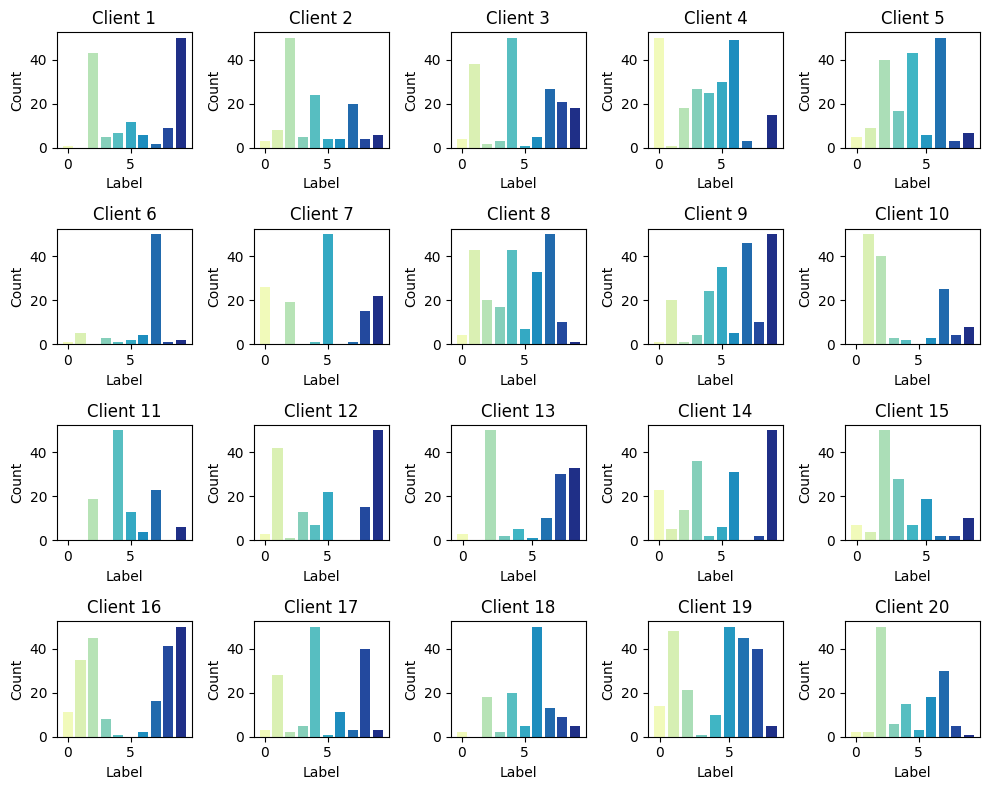

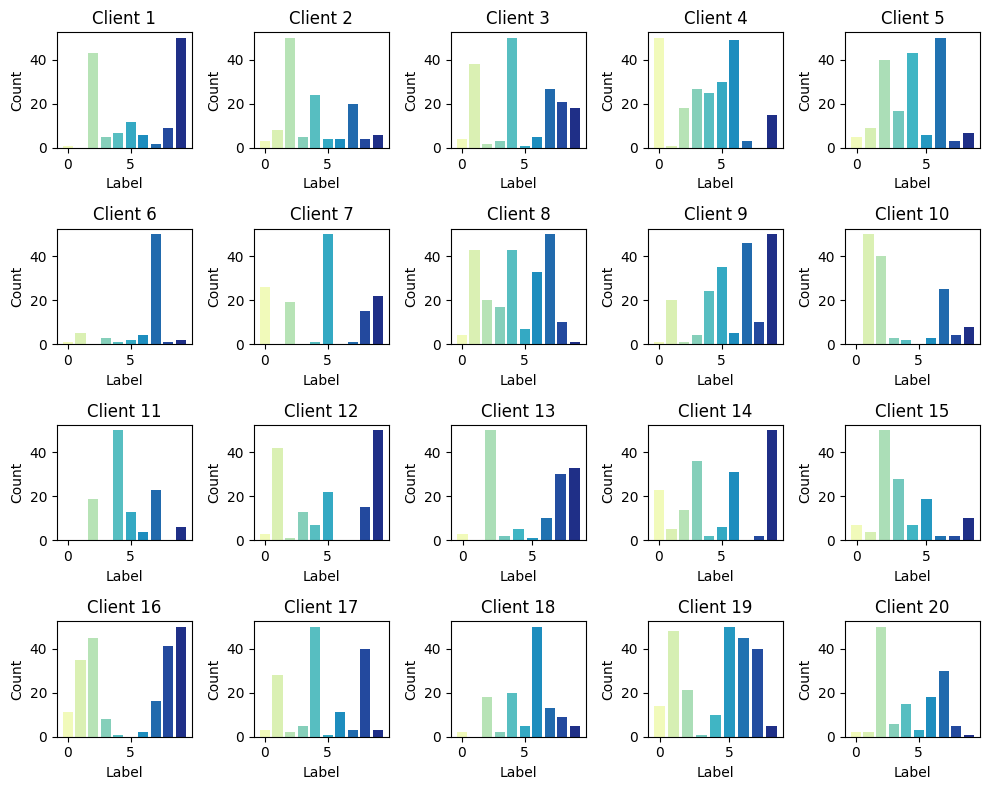

In [ ]:
plot_label_distribution(test_unbalanced_train_loaders)
plot_label_distribution(test_unbalanced_train_loaders)

# CNN

In [ ]:

def train(net, trainloader, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for _ in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return loss, accuracy

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)        # 1 input channel (grayscale), 10 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(10, 32, 5)       # 10 input channels, 32 output channels, 5x5 kernel
        self.conv3 = nn.Conv2d(32, 64, 3)       # 32 input channels, 64 output channels, 3x3 kernel
        self.pool  = nn.MaxPool2d(2, 2)         # 2x2 pooling layer
        self.fc1   = nn.Linear(256, 128)        # Dense layer
        self.fc2   = nn.Linear(128, 64)         # Dense layer
        self.fc3   = nn.Linear(64, 10)          # 64 inputs, 10 outputs for the 10 classes
        # Steps:
            # Conv1: 28x28 -> 24x24 (28 - 5 + 1)
            # Pool:  24x24 -> 12x12 (24 / 2)
            # Conv2: 12x12 -> 8x8   (12 - 5 + 1)
            # Pool:  8x8   -> 4x4   (8 / 2)
            # Conv3: 4x4   -> 2x2   (4 - 3 + 1)
            # Flatn: 2x2   -> 1x256 (2 * 2 * 64)
            # Dense: 1x256 -> 1x128
            # Dense: 1x128 -> 1x64
            # Dense: 1x64  -> 1x10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (12, 12, 10)
        x = self.pool(F.relu(self.conv2(x))) # (4, 4, 32)
        x = F.relu(self.conv3(x))            # (2, 2, 64)
        x = x.view(-1, 256)                  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Client

In [ ]:
class Client(fl.client.NumPyClient):
    def __init__(self, net, train_loader, test_loader, num_examples):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.net = net
        self.num_examples = num_examples

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.train_loader, epochs=4)
        _, accuracy = test(self.net, self.test_loader)
        return self.get_parameters(config={}), self.num_examples["trainset"], {"accuracy": accuracy}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.test_loader)
        return float(loss), self.num_examples["testset"], {"accuracy": float(accuracy)}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_client_fn(train_loaders, test_loaders, num_examples):
    """Return a function to construct a client.

    """

    def client_fn(cid: str) -> Client:
        train_loader = train_loaders[int(cid)]
        test_loader = test_loaders[int(cid)]
        net = Net().to(DEVICE)

        # print(f"cid: {int(cid)}")

        return Client(net, train_loader, test_loader, num_examples).to_client()

    return client_fn

# Strategy

## Method A

In [ ]:
class MethodA(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Calculate accuracies for each client, create a dictionary and DataFrame for the round, and compute the mean accuracy
        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}
        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)


        # Update accuracies, losses, and the accuracy DataFrame with the current round's data
        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])


        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def plot_loss_per_client_per_round(self):
        num_rounds = len(self.losses)
        num_clients = len(self.losses[0])

        plt.figure()
        for client_idx in range(num_clients):
            plt.plot(range(1, num_rounds + 1), [self.losses[r][client_idx] for r in range(num_rounds)], marker='o', label=f'Client {client_idx + 1}')

        plt.title("Loss per Client per Round")
        plt.xlabel("Round")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)


    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

## Method B

In [ ]:
class MethodB(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.probability_df = pd.DataFrame()

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            selected_clients = client_manager.sample(num_clients=sample_size, min_num_clients=sample_size)

            # store round probabilities
            round_probabilities = {f"Client {cid + 1}": self.p for cid in range(self.num_clients)}

        else:
            # Round t: Nodes have selection probability based on accuracy from previous round
            selected_clients = []
            round_probabilities = {}

            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = np.exp(-1.5 * last_round_accuracy)
                else:
                    prob = self.p

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob:
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients - 1))])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        fit_ins = FitIns(parameters, {})

        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

## Method C

In [ ]:
class MethodC(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = [] # Store avg accuracies for each round
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.probability_df = pd.DataFrame()

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        print(f"server_round: {server_round}")

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            selected_clients = client_manager.sample(num_clients=sample_size, min_num_clients=sample_size)

            # store round probabilities
            round_probabilities = {f"Client {cid + 1}": self.p for cid in range(self.num_clients)}

        else:
            print(f"server_round: {server_round}")
            # Round t: Nodes have selection probability based on accuracy from previous round
            selected_clients = []
            round_probabilities = {}

            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = np.exp(-1.5 * last_round_accuracy)
                else:
                    prob = self.probability_df[client_key].iloc[-1]

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob:
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients - 1))])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        fit_ins = FitIns(parameters, {})

        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

## Method D

In [ ]:
class MethodD(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.probability_df = pd.DataFrame()
        self.availability_df = pd.DataFrame()  # DataFrame to store availability matrix

        self.state = {f"Client {i + 1}": "ON" for i in range(num_clients)}  # state for each clinet (all are 'ON' at the beginning)
        self.p1_dict = {f"Client {i + 1}": np.random.uniform() for i in range(num_clients)}  # Random p1 for each client
        self.p2_dict = {f"Client {i + 1}": np.random.uniform() for i in range(num_clients)}  # Random p2 for each client

        print("Initial p1 values:")
        for client, p1 in self.p1_dict.items():
            print(f"{client}: {p1}")

        print("\nInitial p2 values:")
        for client, p2 in self.p2_dict.items():
            print(f"{client}: {p2}")

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        selected_clients = []
        round_probabilities = {}

        # check transition of availablity
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if self.state[client_key] == "ON":
                if np.random.rand() <= self.p1_dict[client_key]:
                    self.state[client_key] = "OFF"
            elif self.state[client_key] == "OFF":
                if np.random.rand() <= self.p2_dict[client_key]:
                    self.state[client_key] = "ON"

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if np.random.rand() <= self.p and self.state[client_key] == "ON":
                    selected_clients.append(all_clients[str(client_cid)])

                # store round probabilities
                round_probabilities[client_key] = self.p
        else:
            # Round t: Nodes have selection probability based on accuracy from previous round
            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = np.exp(-1.5 * last_round_accuracy)
                else:
                    prob = self.probability_df[client_key].iloc[-1]

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob and self.state[client_key] == "ON":
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients - 1))])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        # Update availability dataframe
        availability_dict = {}
        for client_key, state in self.state.items():
            availability_dict[client_key] = 1 if state == "ON" else 0

        avail_df = pd.DataFrame(availability_dict, index=[server_round])
        self.availability_df = pd.concat([self.availability_df, avail_df])

        # finish configure_fit
        fit_ins = FitIns(parameters, {})
        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

# Start Simulation

In [ ]:
NUM_CLIENTS = 20
ROUND = 50

def get_evaluate_server_fn(model, test_loader):
    def evaluate_fn(server_round, parameters, config):
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        loss, accuracy = test(model, test_loader)
        return loss, {"accuracy": accuracy}
    return evaluate_fn

def start_simulation(train_loaders, test_loaders, strategy):
    train_set_length = sum(len(loader.dataset) for loader in train_loaders)
    test_set_length = sum(len(loader.dataset) for loader in test_loaders)
    num_examples = {"trainset": train_set_length, "testset": test_set_length}

    # Start simulation
    fl.simulation.start_simulation(
        client_fn=get_client_fn(train_loaders, test_loaders, num_examples),
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=ROUND),
        strategy=strategy
    )


    strategy.plot_accuracies()
    strategy.print_accuracy_matrix()

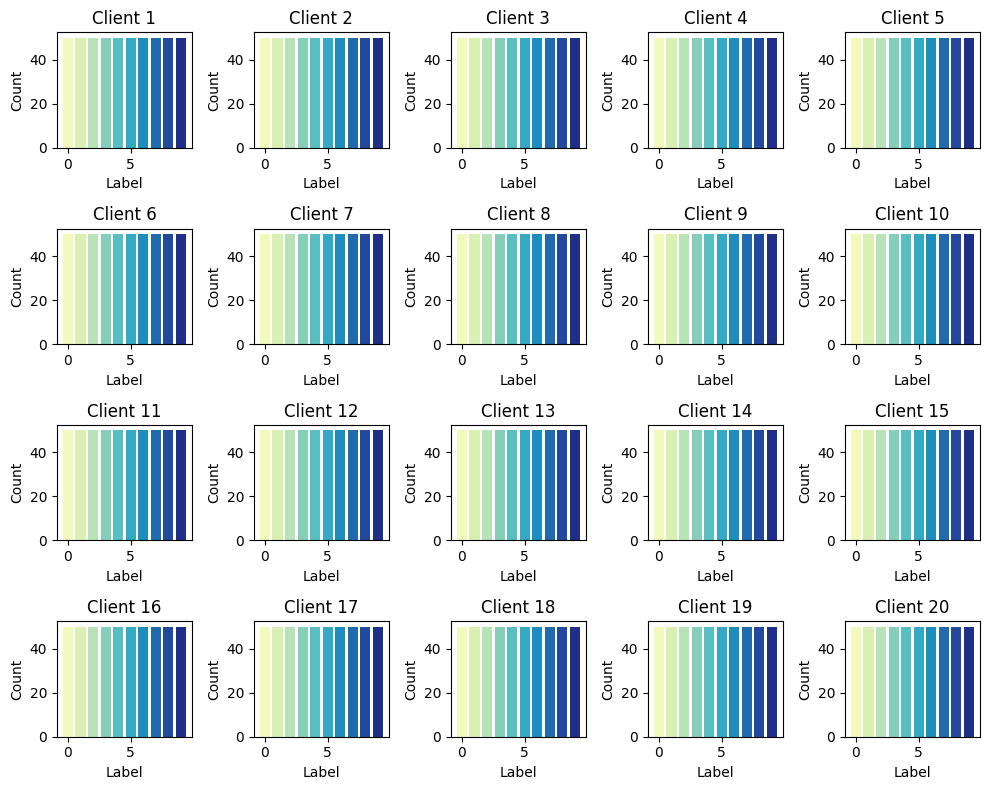

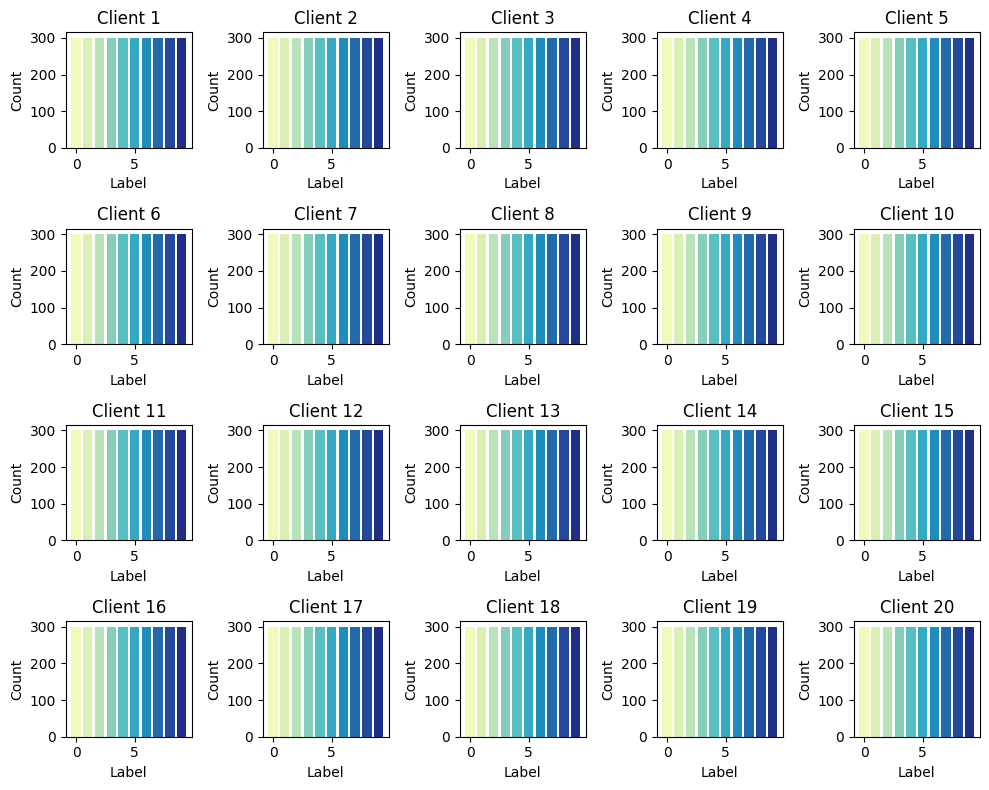

In [ ]:
fashion_mnist_dataloader = MnistDataloader(test_filepath, train_filepath)

(fashion_mnist_X_train, fashion_mnist_y_train), (fashion_mnist_X_test, fashion_mnist_y_test) = fashion_mnist_dataloader.load_data()

fashion_mnist_train_iid_loaders, fashion_mnist_test_iid_loaders = split_dataset_balanced(NUM_CLIENTS, fashion_mnist_X_train, fashion_mnist_y_train, fashion_mnist_X_test, fashion_mnist_y_test)

plot_label_distribution(fashion_mnist_train_iid_loaders)
plot_label_distribution(fashion_mnist_test_iid_loaders)

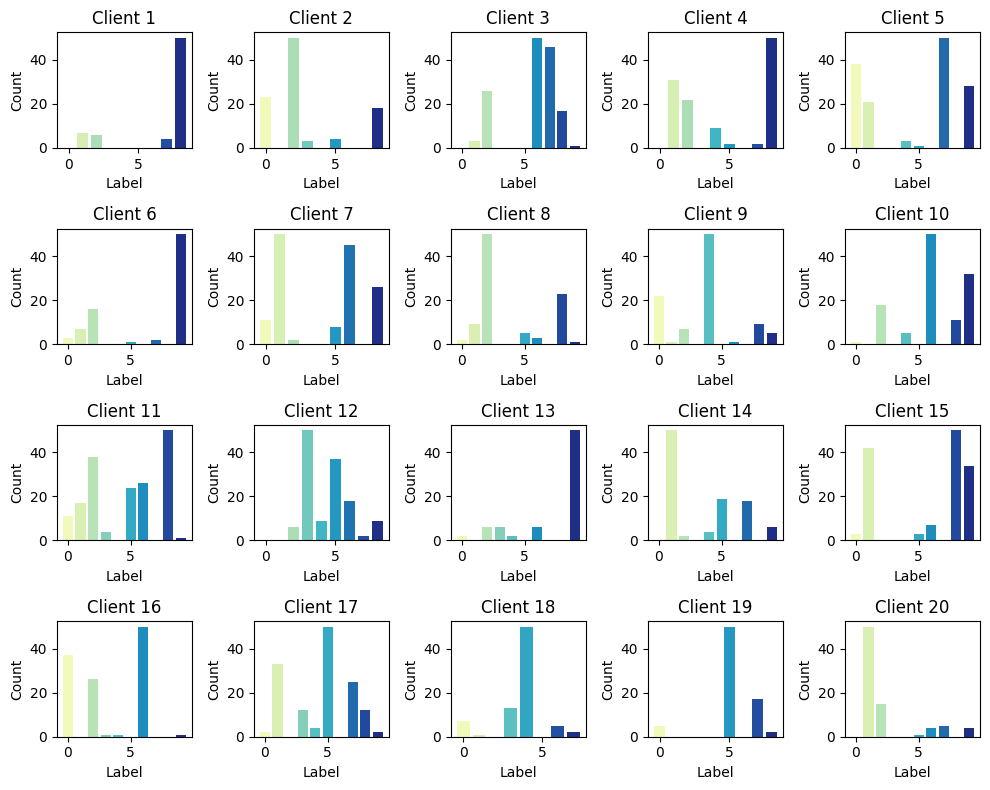

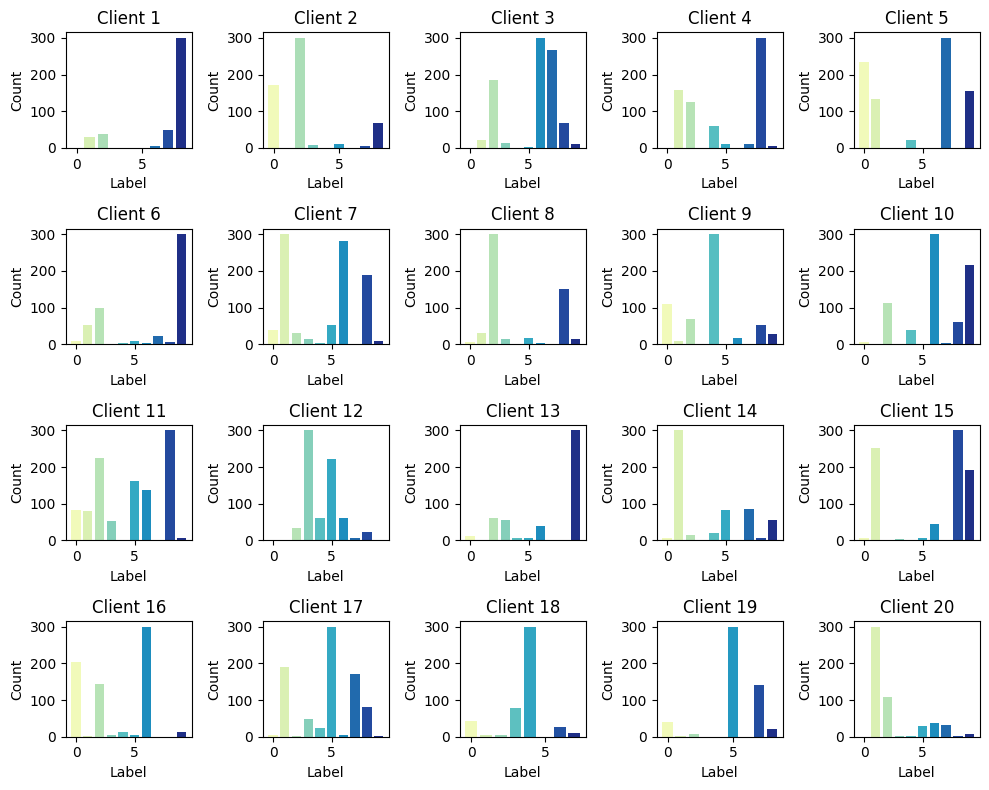

In [ ]:
fashion_mnist_train_non_iid_loaders, fashion_mnist_test_non_iid_loaders = create_unbalanced_loaders(fashion_mnist_train_iid_loaders, fashion_mnist_test_iid_loaders, 10, alpha=0.3)

plot_label_distribution(fashion_mnist_train_non_iid_loaders)
plot_label_distribution(fashion_mnist_test_non_iid_loaders)

### Fashion MNIST - Method A - iid data

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-22 03:33:43,285	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 8021940635.0, 'object_store_memory': 4010970316.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

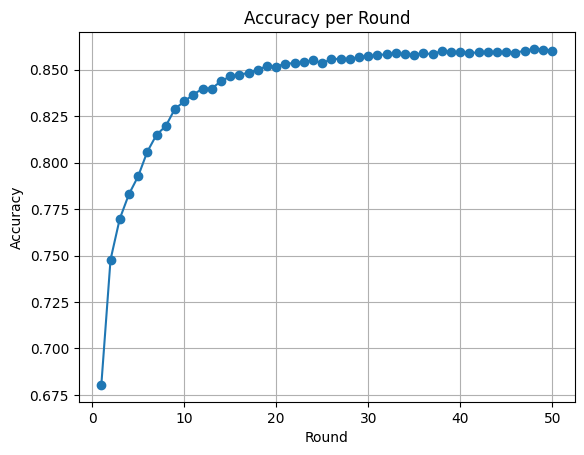

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.677000  0.682000  0.675333  0.680667  0.676667  0.670000  0.669667   
2   0.746000  0.752333  0.740000  0.742000  0.755000  0.747000  0.742333   
3   0.761667  0.770000  0.767667  0.765000  0.765333  0.771667  0.768333   
4   0.784000  0.785000  0.772667  0.777333  0.782667  0.787667  0.785667   
5   0.790667  0.788000  0.784333  0.792000  0.795667  0.795667  0.793333   
6   0.810333  0.808000  0.801000  0.804667  0.807667  0.807333  0.811000   
7   0.812333  0.806667  0.810333  0.811333  0.812667  0.813000  0.825000   
8   0.820000  0.828000  0.825667  0.820667  0.823667  0.822667  0.823000   
9   0.836333  0.827333  0.829000  0.824667  0.818000  0.830000  0.827333   
10  0.820000  0.832667  0.839333  0.830667  0.831000  0.837667  0.835667   
11  0.835333  0.838333  0.833667  0.836667  0.840000  0.836667  0.847333   
12  0.837000  0.838333  0.840667  0.839667  0.848333  0.

In [ ]:
fashion_mnist_iid_strategy_A = MethodA(evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), fashion_mnist_dataloader.test_loader))

start_simulation(fashion_mnist_train_iid_loaders, fashion_mnist_test_iid_loaders, fashion_mnist_iid_strategy_A)
fashion_mnist_iid_strategy_A.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/iid_strategy_A_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### Fashion MNIST - Method A - non iid data

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-22 04:58:43,934	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 4015996108.0, 'memory': 8031992219.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

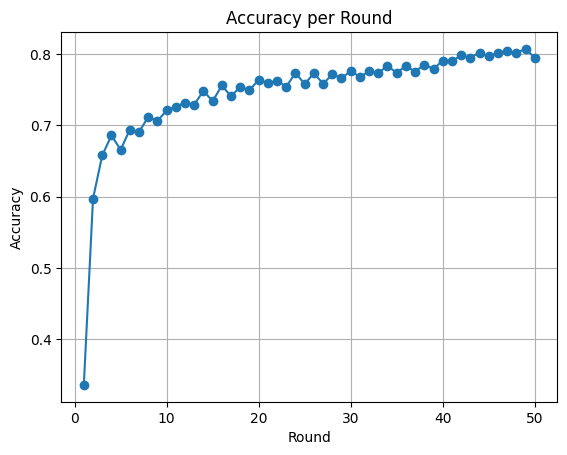

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.536145  0.179245  0.164789  0.562745  0.410824  0.281573  0.115646   
2   0.814176  0.854859  0.849722  0.051173  0.266323  0.884692  0.638938   
3   0.858847  0.797170  0.833333  0.308451  0.826549  0.469388  0.592593   
4   0.894249  0.802682  0.615468  0.472914  0.560414  0.819469  0.754217   
5   0.787425  0.747412  0.507483  0.843788  0.405498  0.842912  0.123667   
6   0.860177  0.851415  0.837128  0.429553  0.840614  0.465593  0.618736   
7   0.846517  0.574223  0.898608  0.806886  0.755694  0.877551  0.872154   
8   0.805383  0.901670  0.740210  0.772289  0.446735  0.851240  0.902584   
9   0.472914  0.768116  0.529252  0.872642  0.881262  0.832335  0.422535   
10  0.650327  0.798039  0.813665  0.759312  0.493411  0.536620  0.889299   
11  0.792961  0.508591  0.769880  0.873905  0.867769  0.860177  0.317697   
12  0.902584  0.594937  0.309168  0.853601  0.487555  0.

In [ ]:
fashion_mnist_non_iid_strategy_A = MethodA(evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), fashion_mnist_dataloader.test_loader))

start_simulation(fashion_mnist_train_non_iid_loaders, fashion_mnist_test_non_iid_loaders, fashion_mnist_non_iid_strategy_A)
fashion_mnist_non_iid_strategy_A.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/non_iid_strategy_A_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### Fashion MNIST - Method B - iid data

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-22 05:59:19,667	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 8044938855.0, 'object_store_memory': 4022469427.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

Serial number of the client selected to fit: ['4', '0', '5', '17', '10', '18', '9', '13', '3', '12']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 1701.9325725138187, {'accuracy': 0.6859833333333333}, 49.61078391999945)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '0', '5', '17', '10', '18', '9', '13', '3', '12']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['3', '4', '5', '6', '11', '12', '16', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (2, 1304.4105763584375, {'accuracy': 0.7334}, 109.67766707800001)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '4', '5', '6', '11', '12', '16', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '15', '17', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (3, 1170.4342058748007, {'accuracy': 0.7634166666666666}, 158.4706910069999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '15', '17', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '7', '9', '10', '13', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (4, 1092.615594804287, {'accuracy': 0.77965}, 201.18572452899934)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '7', '9', '10', '13', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '4', '6', '12', '14', '17']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (5, 1053.904488220811, {'accuracy': 0.7923}, 248.99685901500015)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '6', '12', '14', '17']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '4', '6', '11', '12', '15', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (6, 999.1179793477058, {'accuracy': 0.8049666666666667}, 304.4943713819994)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '6', '11', '12', '15', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['3', '5', '8', '10', '13', '14', '16', '17', '18', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 955.0928191393614, {'accuracy': 0.8165}, 360.7449432779995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '5', '8', '10', '13', '14', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '4', '11', '12', '14', '15', '16']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (8, 926.4571849778295, {'accuracy': 0.8252166666666667}, 417.48225214899867)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '4', '11', '12', '14', '15', '16']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (9, 900.4060916155577, {'accuracy': 0.8314}, 480.84930436600007)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '7', '9', '13']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (10, 890.4313048496842, {'accuracy': 0.8351166666666666}, 534.8714786429991)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '7', '9', '13']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['3', '8', '12', '14', '15', '18', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (11, 890.122277148068, {'accuracy': 0.8371166666666666}, 578.7326888709995)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '8', '12', '14', '15', '18', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '4', '6', '7', '11', '14']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (12, 871.8375954292715, {'accuracy': 0.839}, 625.7684263819992)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '4', '6', '7', '11', '14']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['1', '5', '6', '7', '8', '10', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (13, 863.7238220609725, {'accuracy': 0.8449833333333333}, 687.6513840989992)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '6', '7', '8', '10', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '4', '5', '9', '11', '12', '14', '15', '16', '18']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (14, 849.416966021061, {'accuracy': 0.8460333333333333}, 753.217467950999)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '4', '5', '9', '11', '12', '14', '15', '16', '18']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['3', '6', '10', '11', '12', '13', '16', '17']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (15, 851.4619471356273, {'accuracy': 0.8471333333333333}, 807.1553624049993)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '6', '10', '11', '12', '13', '16', '17']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '4', '5', '7', '14', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (16, 865.1686459667981, {'accuracy': 0.8491666666666666}, 851.6097835799992)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '5', '7', '14', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '6', '8', '9', '10', '12', '13', '14', '15', '16', '17']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (17, 822.7057794742286, {'accuracy': 0.8507333333333333}, 902.8852050629994)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '6', '8', '9', '10', '12', '13', '14', '15', '16', '17']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '4', '7', '9', '18', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (18, 850.4599819667637, {'accuracy': 0.85405}, 955.4382688690002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '4', '7', '9', '18', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['2', '6', '8', '9', '12', '14', '16', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (19, 849.5300610084087, {'accuracy': 0.8534333333333334}, 1005.7074008849995)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '6', '8', '9', '12', '14', '16', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '4', '6', '7', '8', '15', '16', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (20, 839.6759488023818, {'accuracy': 0.8554666666666667}, 1055.3998595289995)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '6', '7', '8', '15', '16', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '5', '7', '8', '10', '11', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (21, 860.0353763364255, {'accuracy': 0.8553833333333334}, 1101.4337890839997)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '5', '7', '8', '10', '11', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['1', '6', '10', '11', '13', '14', '15', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (22, 850.3000635877252, {'accuracy': 0.8570166666666666}, 1149.780805889999)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '6', '10', '11', '13', '14', '15', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '5', '6', '9', '14', '16']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (23, 844.0501160994172, {'accuracy': 0.8562833333333333}, 1197.9853080489993)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '5', '6', '9', '14', '16']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['4', '7', '9', '11', '12', '15', '18', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (24, 864.7872743085027, {'accuracy': 0.8583}, 1244.9744042559996)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '7', '9', '11', '12', '15', '18', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '4', '5', '6', '12', '13', '14', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (25, 887.7645689062774, {'accuracy': 0.85665}, 1291.962207867)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '5', '6', '12', '13', '14', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '9', '11', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (26, 844.8685791902244, {'accuracy': 0.8584166666666667}, 1329.9106481009985)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '9', '11', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '5', '6', '7', '8', '9', '11', '14', '15', '17', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (27, 852.6217806152999, {'accuracy': 0.8616833333333334}, 1378.4191851399992)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '5', '6', '7', '8', '9', '11', '14', '15', '17', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '9', '12', '13', '15', '16', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (28, 858.531910751015, {'accuracy': 0.8588666666666667}, 1430.0190275759996)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '9', '12', '13', '15', '16', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '5', '8', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (29, 862.5179246515036, {'accuracy': 0.8589333333333333}, 1470.6507504909987)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '5', '8', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '5', '6', '7', '13', '14', '15', '16', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (30, 864.9114248212427, {'accuracy': 0.8616}, 1519.7488981709994)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '6', '7', '13', '14', '15', '16', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '6', '8', '9', '10', '11', '12', '17', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (31, 858.2823408469558, {'accuracy': 0.8642166666666666}, 1574.4784367949997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '6', '8', '9', '10', '11', '12', '17', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '5', '7', '8', '9', '11', '13']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (32, 868.3135341499001, {'accuracy': 0.8627333333333334}, 1630.309656035999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '5', '7', '8', '9', '11', '13']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['4', '6', '7', '13', '15', '16', '17', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (33, 895.6620611213148, {'accuracy': 0.8628666666666667}, 1679.7516031229989)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '6', '7', '13', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '7', '11', '15']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (34, 906.0812148563564, {'accuracy': 0.86025}, 1721.8530033239986)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '7', '11', '15']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '4', '6', '8', '13', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (35, 918.659126217477, {'accuracy': 0.8607166666666667}, 1763.298063852999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '6', '8', '13', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '5', '7', '9', '10', '13', '14', '16']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (36, 886.8378680460155, {'accuracy': 0.8641833333333333}, 1810.0556172069992)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '5', '7', '9', '10', '13', '14', '16']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '6', '7', '12', '14']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (37, 904.3486153259873, {'accuracy': 0.86165}, 1855.077572311)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '6', '7', '12', '14']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['3', '4', '6', '7', '8', '9', '10', '15', '16', '17', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (38, 896.3933617342263, {'accuracy': 0.8657}, 1907.5561552090003)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '4', '6', '7', '8', '9', '10', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '5', '6', '12', '14', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (39, 920.2205918300897, {'accuracy': 0.86575}, 1957.3342472629993)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '5', '6', '12', '14', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '5', '7', '8', '12', '14', '15', '16', '17', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (40, 926.3931475915015, {'accuracy': 0.86385}, 2008.6849638989988)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '5', '7', '8', '12', '14', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '4', '6', '11', '13', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (41, 939.4412284139544, {'accuracy': 0.8634666666666667}, 2057.089778316)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '4', '6', '11', '13', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '8', '9', '11', '12', '14', '17']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (42, 942.2997565437108, {'accuracy': 0.8646833333333334}, 2102.683502832)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '8', '9', '11', '12', '14', '17']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['3', '5', '7', '8', '10', '11', '16', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (43, 952.0868748724461, {'accuracy': 0.8658166666666667}, 2152.1760496749994)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '5', '7', '8', '10', '11', '16', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '4', '9', '12', '14', '18', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (44, 952.8074769871309, {'accuracy': 0.8660833333333333}, 2200.7473139569993)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '4', '9', '12', '14', '18', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '4', '6', '7', '8', '9', '10', '11', '13', '14', '15', '17']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (45, 940.522469826974, {'accuracy': 0.8663666666666666}, 2262.429515402)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '6', '7', '8', '9', '10', '11', '13', '14', '15', '17']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['3', '5', '11', '12', '18']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (46, 993.7246396653354, {'accuracy': 0.86235}, 2311.785054172)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '5', '11', '12', '18']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['7', '11', '13', '14']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (47, 1047.8221234744415, {'accuracy': 0.86345}, 2344.675363246999)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '11', '13', '14']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '4', '9', '12', '15', '17', '18', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (48, 988.440347103402, {'accuracy': 0.8660833333333333}, 2383.417281353999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '9', '12', '15', '17', '18', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '6', '7', '10', '11', '15', '16']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (49, 960.5189877487719, {'accuracy': 0.8677}, 2434.390384463999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '6', '7', '10', '11', '15', '16']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['4', '8', '9', '18', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (50, 991.2916719019413, {'accuracy': 0.8675166666666667}, 2477.3490796309998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '8', '9', '18', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 2484.08s
INFO :      	History (loss, distributed):
INFO :      		round 1: 85.23252161256968
INFO :      		round 2: 65.44483183200161
INFO :      		round 3: 59.30421802937053
INFO :      		round 4: 54.62889602399081
INFO :      		round 5: 52.25315409666291
INFO :      		round 6: 49.853392829323035
INFO :      		round 7: 48.26782480025431
INFO :      		round 8: 45.80981535327414
INFO :      		round 9: 45.33324698788298
INFO :      		round 10: 44.195700705458876
INFO :      		round 11: 44.26319553186269
INFO :      		round 12: 42.857764675674844
INFO :      		round 13: 43.263877511680526
INFO :      		round 14: 42.56183215217573
INFO :      		round 15: 42.82504342471839
INFO :      		round 16: 43.08337933985179
INFO :      		round 17: 41.630674727267674
INFO :      		round 18: 42.38337315254831
INFO :      		round 19: 42.187423407973256
INFO :      	

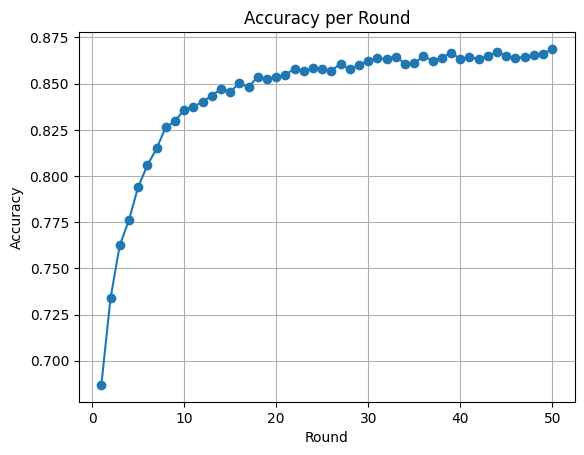

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.693333       NaN       NaN  0.684000  0.702667  0.680333       NaN   
2   0.693333       NaN       NaN  0.735333  0.736000  0.727333  0.745000   
3   0.693333       NaN  0.760667  0.763333  0.766333  0.727333  0.745000   
4   0.772667       NaN  0.760667  0.763333  0.766333  0.727333  0.745000   
5   0.785667  0.800333  0.789667  0.763333  0.791667  0.727333  0.796333   
6   0.800667  0.800333  0.805000  0.808333  0.808333  0.727333  0.806333   
7   0.800667  0.800333  0.805000  0.813000  0.808333  0.824333  0.806333   
8   0.821667  0.833333  0.805000  0.821333  0.827000  0.824333  0.806333   
9   0.821667  0.833333  0.829333  0.829667  0.827000  0.824333  0.806333   
10  0.826333  0.842667  0.837667  0.829667  0.827000  0.824333  0.806333   
11  0.826333  0.842667  0.837667  0.835667  0.827000  0.824333  0.806333   
12  0.838000  0.843000  0.837667  0.835667  0.843667  0.

In [ ]:
fashion_mnist_iid_strategy_B = MethodB(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), fashion_mnist_dataloader.test_loader))

start_simulation(fashion_mnist_train_iid_loaders, fashion_mnist_test_iid_loaders, fashion_mnist_iid_strategy_B)
fashion_mnist_iid_strategy_B.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/iid_strategy_B_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
fashion_mnist_iid_strategy_B.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/iid_strategy_B_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### Fashion MNIST - Method B - non iid data

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-22 09:07:01,622	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 8043125147.0, 'object_store_memory': 4021562572.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

Serial number of the client selected to fit: ['13', '14', '9', '12', '16', '11', '5', '4', '0', '10']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 3849.6075568199158, {'accuracy': 0.3872}, 32.09691896300137)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['13', '14', '9', '12', '16', '11', '5', '4', '0', '10']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '4', '6', '7', '9', '10', '11', '16', '17', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (2, 3315.8510386943817, {'accuracy': 0.4049833333333333}, 74.3777967950009)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '4', '6', '7', '9', '10', '11', '16', '17', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '5', '7', '9', '11', '12', '14', '17', '18']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (3, 2993.239251971245, {'accuracy': 0.38845}, 115.14225665599952)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '5', '7', '9', '11', '12', '14', '17', '18']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '5', '6', '10', '11', '15', '17', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (4, 2724.8630369901657, {'accuracy': 0.49441666666666667}, 154.1536572619989)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '5', '6', '10', '11', '15', '17', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '4', '8', '10', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (5, 2193.0102056860924, {'accuracy': 0.5820333333333333}, 192.62254445600047)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '8', '10', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '6', '10', '11', '13', '14', '15', '18']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (6, 2867.9774074554443, {'accuracy': 0.5214333333333333}, 233.97137700999883)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '6', '10', '11', '13', '14', '15', '18']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 15 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '5', '6', '7', '8', '9', '11', '12', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 15 results and 0 failures
INFO :      fit progress: (7, 2056.0956795215607, {'accuracy': 0.6028}, 277.6080807819999)
INFO :      configure_evaluate: strategy sampled 15 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '5', '6', '7', '8', '9', '11', '12', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '5', '15', '17', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (8, 2013.6049726307392, {'accuracy': 0.6306333333333334}, 316.82996088399887)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '5', '15', '17', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['4', '5', '6', '9', '14', '16', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (9, 2454.639379799366, {'accuracy': 0.5969166666666667}, 347.1855012070009)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '5', '6', '9', '14', '16', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '6', '8', '10', '11', '17', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (10, 2317.442854464054, {'accuracy': 0.52475}, 378.79614696299905)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '6', '8', '10', '11', '17', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '6', '7', '8', '11', '14', '15', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (11, 2540.464410305023, {'accuracy': 0.5668}, 413.1968263769995)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '6', '7', '8', '11', '14', '15', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '7', '8', '10', '11', '12', '17']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (12, 1676.1275751888752, {'accuracy': 0.70565}, 446.62558015600007)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '7', '8', '10', '11', '12', '17']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '5', '8', '10', '13']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (13, 2779.3170603215694, {'accuracy': 0.5813333333333334}, 476.6240376850001)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '5', '8', '10', '13']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '4', '6', '9', '12', '15', '16', '17', '18']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (14, 1628.1451709866524, {'accuracy': 0.65125}, 509.83988176300045)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '4', '6', '9', '12', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '5', '7', '9', '10', '13', '16', '17', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (15, 1916.131033539772, {'accuracy': 0.6598833333333334}, 548.5310075410016)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '7', '9', '10', '13', '16', '17', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['4', '6', '8', '11', '14', '16', '17', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (16, 1779.5216107666492, {'accuracy': 0.6687}, 583.191110931999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '6', '8', '11', '14', '16', '17', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '4', '5', '10', '12', '13', '15', '16']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (17, 1830.6899336576462, {'accuracy': 0.66095}, 616.2412523460007)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '5', '10', '12', '13', '15', '16']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '6', '9', '10', '14', '15', '17', '18']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (18, 1517.1617586612701, {'accuracy': 0.6841166666666667}, 652.9782416400012)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '6', '9', '10', '14', '15', '17', '18']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['5', '7', '11', '12', '15', '18', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (19, 1787.5073539465666, {'accuracy': 0.6845}, 686.2754501820018)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '7', '11', '12', '15', '18', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '4', '5', '9', '12', '15', '16']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (20, 1571.0786789953709, {'accuracy': 0.68125}, 716.6955926699993)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '4', '5', '9', '12', '15', '16']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['8', '9', '10', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 1423.1421158909798, {'accuracy': 0.7006166666666667}, 743.8319328910002)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '9', '10', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '4', '9', '10', '11', '12', '14', '15', '16']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (22, 1381.2350614964962, {'accuracy': 0.7109}, 774.4108354640011)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '4', '9', '10', '11', '12', '14', '15', '16']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '5', '7', '15', '16', '17', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (23, 1444.1826715320349, {'accuracy': 0.7033666666666667}, 808.7473368479987)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '5', '7', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '6', '11', '12', '15']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (24, 1477.7627919912338, {'accuracy': 0.6631833333333333}, 840.2528983650009)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '6', '11', '12', '15']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '5', '7', '8', '9', '10', '16', '17', '18', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (25, 1466.7245620191097, {'accuracy': 0.7163833333333334}, 875.9986388729994)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '5', '7', '8', '9', '10', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '6', '9', '13', '14']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (26, 1603.5510308146477, {'accuracy': 0.6850333333333334}, 909.340638048001)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '6', '9', '13', '14']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '9', '10', '11', '13']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (27, 1806.8393543958664, {'accuracy': 0.6772333333333334}, 939.4474804429992)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '9', '10', '11', '13']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '7', '8', '10', '11', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (28, 1289.9835118800402, {'accuracy': 0.74415}, 976.1105267640014)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '7', '8', '10', '11', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '5', '6', '7', '8', '9', '12', '13', '15', '18', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (29, 1775.785207465291, {'accuracy': 0.6835833333333333}, 1016.5182361939987)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '5', '6', '7', '8', '9', '12', '13', '15', '18', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '9', '11', '13', '16', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (30, 1261.4307581931353, {'accuracy': 0.7394166666666667}, 1052.904470163001)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '9', '11', '13', '16', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '5', '6', '7', '8', '9', '10', '14', '15', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (31, 1753.4175815284252, {'accuracy': 0.651}, 1087.906518615)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '5', '6', '7', '8', '9', '10', '14', '15', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '9', '13', '15', '16', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (32, 1407.847138673067, {'accuracy': 0.7078833333333333}, 1122.2208797929998)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '9', '13', '15', '16', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '4', '5', '12', '15', '17', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (33, 1439.643363326788, {'accuracy': 0.7227166666666667}, 1153.4658602119998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '4', '5', '12', '15', '17', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['3', '4', '10', '11', '14']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (34, 1211.7710693776608, {'accuracy': 0.7631833333333333}, 1181.758157608001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '4', '10', '11', '14']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '4', '9', '10', '12', '16', '17', '18', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (35, 1246.4734522402287, {'accuracy': 0.7477}, 1214.5256326589988)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '4', '9', '10', '12', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '6', '8', '10', '11', '15', '17', '18']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (36, 1235.539004817605, {'accuracy': 0.7415666666666667}, 1250.349760109002)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '6', '8', '10', '11', '15', '17', '18']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '11', '12']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (37, 1543.0363993942738, {'accuracy': 0.7309833333333333}, 1279.7630312389992)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '11', '12']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '10', '14', '16', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (38, 1409.9899444431067, {'accuracy': 0.6934166666666667}, 1304.9486646149999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '10', '14', '16', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '6', '7', '10', '15', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (39, 1596.013747960329, {'accuracy': 0.6902333333333334}, 1332.9782139490017)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '6', '7', '10', '15', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['2', '7', '9', '10', '13', '16', '17', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (40, 1288.0766724944115, {'accuracy': 0.7310666666666666}, 1364.0842510760012)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '7', '9', '10', '13', '16', '17', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '5', '9', '11', '12', '14', '16']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (41, 1655.595003992319, {'accuracy': 0.7089666666666666}, 1396.0996141819996)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '5', '9', '11', '12', '14', '16']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['3', '8', '11', '13', '15', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (42, 1264.1948325634003, {'accuracy': 0.7468166666666667}, 1426.2270839890007)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '8', '11', '13', '15', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '5', '6', '7', '9', '10', '11', '12', '16', '17', '18']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (43, 1416.3040372431278, {'accuracy': 0.7284333333333334}, 1461.5849689089991)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '6', '7', '9', '10', '11', '12', '16', '17', '18']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '6', '9', '11', '13', '14', '15', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (44, 1359.8787500113249, {'accuracy': 0.7302}, 1503.888506411)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '6', '9', '11', '13', '14', '15', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['2', '8', '11', '14', '16', '18', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (45, 1148.0190354287624, {'accuracy': 0.7751666666666667}, 1537.8454578439996)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '8', '11', '14', '16', '18', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '7', '10', '14', '16', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (46, 1545.8968575000763, {'accuracy': 0.7214166666666667}, 1567.0778359750002)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '7', '10', '14', '16', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '5', '7', '8', '9', '11', '15', '17', '18', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (47, 1146.0264584422112, {'accuracy': 0.7705166666666666}, 1602.178484467)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '7', '8', '9', '11', '15', '17', '18', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '4', '6', '8', '10', '12', '13', '16', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (48, 1401.9287589639425, {'accuracy': 0.73485}, 1641.0449787260004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '4', '6', '8', '10', '12', '13', '16', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '5', '8', '11', '12', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (49, 1180.040907934308, {'accuracy': 0.7697833333333334}, 1674.068341618)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '8', '11', '12', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '6', '8', '13', '16', '17', '18']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (50, 1226.7247858196497, {'accuracy': 0.7608666666666667}, 1706.3059802179996)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '6', '8', '13', '16', '17', '18']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 1715.63s
INFO :      	History (loss, distributed):
INFO :      		round 1: 41.884542524814606
INFO :      		round 2: 33.72984894613425
INFO :      		round 3: 27.97404707019979
INFO :      		round 4: 26.154137038522297
INFO :      		round 5: 21.929983406017225
INFO :      		round 6: 22.88171398639679
INFO :      		round 7: 19.830038262406983
INFO :      		round 8: 16.23153930902481
INFO :      		round 9: 18.712013389383042
INFO :      		round 10: 24.99981289356947
INFO :      		round 11: 22.274112411671215
INFO :      		round 12: 17.01985165849328
INFO :      		round 13: 23.010900364567835
INFO :      		round 14: 18.542329541661523
INFO :      		round 15: 16.75345828011632
INFO :      		round 16: 15.248265573754907
INFO :      		round 17: 14.27807159276886
INFO :      		round 18: 15.276647364551371
INFO :      		round 19: 11.608941291059766
INFO :  

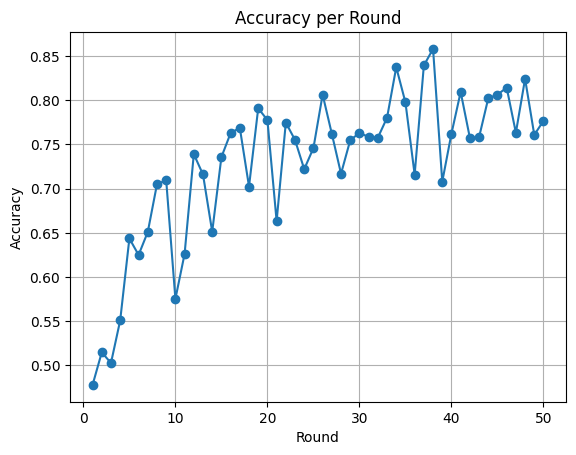

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.287736       NaN       NaN       NaN  0.659976  0.836978       NaN   
2   0.733491  0.552212       NaN  0.727545  0.536009  0.836978  0.527233   
3   0.733491  0.623009  0.492520  0.449102  0.536009  0.815109  0.527233   
4   0.863208  0.623009  0.492520  0.449102  0.536009  0.510934  0.685185   
5   0.830189  0.623009  0.466053  0.782934  0.907910  0.510934  0.685185   
6   0.830189  0.458407  0.432681  0.782934  0.907910  0.510934  0.754902   
7   0.896226  0.883186  0.432681  0.782934  0.907910  0.900596  0.613290   
8   0.875000  0.870796  0.432681  0.812874  0.907910  0.910537  0.613290   
9   0.875000  0.870796  0.432681  0.812874  0.855962  0.747515  0.764706   
10  0.875000  0.858407  0.432681  0.621257  0.855962  0.747515  0.343137   
11  0.849057  0.858407  0.669735  0.621257  0.855962  0.747515  0.833333   
12  0.849057  0.849558  0.669735  0.621257  0.783943  0.

In [ ]:
fashion_mnist_non_iid_strategy_B = MethodB(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), fashion_mnist_dataloader.test_loader))

start_simulation(fashion_mnist_train_non_iid_loaders, fashion_mnist_test_non_iid_loaders, fashion_mnist_non_iid_strategy_B)
fashion_mnist_non_iid_strategy_B.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/non_iid_strategy_B_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
fashion_mnist_non_iid_strategy_B.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/non_iid_strategy_B_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### Fashion MNIST - Method C - iid data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-22 07:18:59,242	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 4008302592.0, 'memory': 8016605184.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flow

server_round: 1
Serial number of the client selected to fit: ['5', '19', '13', '15', '14', '16', '17', '1', '11', '7']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 1525.0888322889805, {'accuracy': 0.69875}, 45.8215999210006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '19', '13', '15', '14', '16', '17', '1', '11', '7']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


server_round: 2
server_round: 2
Serial number of the client selected to fit: ['1', '4', '5', '7', '10', '11', '12', '13', '14', '17', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (2, 1222.0531643480062, {'accuracy': 0.75415}, 107.68546654800048)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '5', '7', '10', '11', '12', '13', '14', '17', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 3
server_round: 3
Serial number of the client selected to fit: ['0', '2', '3', '4', '6', '7', '9', '11', '12', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 1137.8666151314974, {'accuracy': 0.7675666666666666}, 165.03946612099935)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '6', '7', '9', '11', '12', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 4
server_round: 4
Serial number of the client selected to fit: ['0', '2', '4', '11']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 1101.6304369866848, {'accuracy': 0.7755833333333333}, 206.60866783500023)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '11']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 5
server_round: 5
Serial number of the client selected to fit: ['4', '8', '10']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 1031.819429218769, {'accuracy': 0.7951666666666667}, 236.60041500499938)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '8', '10']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 6
server_round: 6
Serial number of the client selected to fit: ['0', '1', '9', '10', '14', '15', '17', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (6, 966.9942061156034, {'accuracy': 0.8136166666666667}, 275.6797831519998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '9', '10', '14', '15', '17', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 7
server_round: 7
Serial number of the client selected to fit: ['3', '8', '12', '14']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 953.8388483449817, {'accuracy': 0.8161666666666667}, 316.5574071239989)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '8', '12', '14']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 8
server_round: 8
Serial number of the client selected to fit: ['12', '14', '15', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 962.3683776110411, {'accuracy': 0.8183333333333334}, 348.4833906740005)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['12', '14', '15', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 9
server_round: 9
Serial number of the client selected to fit: ['0', '1', '5', '9', '10', '15', '17', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (9, 892.691735394299, {'accuracy': 0.83205}, 389.23014327999954)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '5', '9', '10', '15', '17', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 10
server_round: 10
Serial number of the client selected to fit: ['1', '5', '9', '11', '12']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (10, 895.8928536474705, {'accuracy': 0.83335}, 431.89503505299945)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '9', '11', '12']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 11
server_round: 11
Serial number of the client selected to fit: ['4', '13', '15', '17', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (11, 906.6911808103323, {'accuracy': 0.8358666666666666}, 467.5313349429998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '13', '15', '17', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 12
server_round: 12
Serial number of the client selected to fit: ['2', '5', '8', '10', '13']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (12, 887.3237844184041, {'accuracy': 0.8405333333333334}, 502.7150032640002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '5', '8', '10', '13']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 13
server_round: 13
Serial number of the client selected to fit: ['4', '5', '6', '11', '12', '13', '15', '16']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (13, 872.9269646070898, {'accuracy': 0.8427166666666667}, 548.3200901679993)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '5', '6', '11', '12', '13', '15', '16']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 14
server_round: 14
Serial number of the client selected to fit: ['1', '5', '8', '10', '15', '17', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (14, 868.4570775330067, {'accuracy': 0.8475166666666667}, 600.2152020609992)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '8', '10', '15', '17', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 15
server_round: 15
Serial number of the client selected to fit: ['7', '8', '11', '12', '13']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (15, 884.4780467674136, {'accuracy': 0.8448166666666667}, 639.223509681)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '8', '11', '12', '13']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 16
server_round: 16
Serial number of the client selected to fit: ['1', '7', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (16, 890.6330815851688, {'accuracy': 0.8472}, 670.0835676450006)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '7', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 17
server_round: 17
Serial number of the client selected to fit: ['1', '6', '13', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 896.6735811904073, {'accuracy': 0.8503833333333334}, 698.0148120289996)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '6', '13', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 18
server_round: 18
Serial number of the client selected to fit: ['2', '5', '6', '9', '12', '13', '15', '16']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (18, 855.587401535362, {'accuracy': 0.8494166666666667}, 736.7520714450002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '5', '6', '9', '12', '13', '15', '16']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 19
server_round: 19
Serial number of the client selected to fit: ['0', '5', '8', '14', '16', '17', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (19, 881.5480790250003, {'accuracy': 0.8484}, 778.6105783189996)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '5', '8', '14', '16', '17', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 20
server_round: 20
Serial number of the client selected to fit: ['1', '3', '4', '6', '7', '10', '12', '13', '15']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (20, 846.1663385331631, {'accuracy': 0.8539833333333333}, 824.4945736770005)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '6', '7', '10', '12', '13', '15']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 21
server_round: 21
Serial number of the client selected to fit: ['1', '5', '9', '12', '13', '16', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (21, 878.338967744261, {'accuracy': 0.85475}, 868.6688462559996)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '9', '12', '13', '16', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 22
server_round: 22
Serial number of the client selected to fit: ['5', '6', '8', '17', '18', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (22, 881.6411838084459, {'accuracy': 0.8557}, 906.1924740329996)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '6', '8', '17', '18', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 23
server_round: 23
Serial number of the client selected to fit: ['2', '3', '10', '13', '14']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (23, 866.64451463148, {'accuracy': 0.8539333333333333}, 940.5354787679989)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '10', '13', '14']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


server_round: 24
server_round: 24
Serial number of the client selected to fit: ['16', '18']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (24, 991.2968883514404, {'accuracy': 0.83935}, 967.1175830390002)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['16', '18']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 25
server_round: 25
Serial number of the client selected to fit: ['2', '3', '13', '15', '16']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (25, 875.4201589263976, {'accuracy': 0.8547333333333333}, 996.8968895140006)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '13', '15', '16']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 26
server_round: 26
Serial number of the client selected to fit: ['10', '11', '12', '13', '15', '16']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (26, 892.0716103464365, {'accuracy': 0.8555}, 1031.9232267690004)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['10', '11', '12', '13', '15', '16']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 27
server_round: 27
Serial number of the client selected to fit: ['1', '5', '11', '12', '17', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (27, 918.2865992747247, {'accuracy': 0.8574333333333334}, 1066.994536111999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '11', '12', '17', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 28
server_round: 28
Serial number of the client selected to fit: ['6', '11', '14', '17']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 882.1290535181761, {'accuracy': 0.8564833333333334}, 1098.5096777550007)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '11', '14', '17']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 29
server_round: 29
Serial number of the client selected to fit: ['2', '7', '9', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 885.7071716561913, {'accuracy': 0.8604}, 1128.0253626510003)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '7', '9', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 30
server_round: 30
Serial number of the client selected to fit: ['0', '1', '11', '13', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (30, 902.8123617209494, {'accuracy': 0.8596}, 1160.2694321189992)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '11', '13', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 31
server_round: 31
Serial number of the client selected to fit: ['4', '5', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (31, 925.0172464586794, {'accuracy': 0.8569833333333333}, 1189.7754630559994)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '5', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 32
server_round: 32
Serial number of the client selected to fit: ['0', '3', '4', '6', '8', '9', '14', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (32, 867.601613625884, {'accuracy': 0.8620166666666667}, 1227.5143439740004)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '4', '6', '8', '9', '14', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 33
server_round: 33
Serial number of the client selected to fit: ['2', '4', '6', '7', '12', '16', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (33, 902.1786727216095, {'accuracy': 0.8616333333333334}, 1272.5878193079989)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '6', '7', '12', '16', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 34
server_round: 34
Serial number of the client selected to fit: ['0', '1', '3', '6', '9', '11', '14', '15', '17', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (34, 890.7525819838047, {'accuracy': 0.8650333333333333}, 1321.8513440429997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '6', '9', '11', '14', '15', '17', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 35
server_round: 35
Serial number of the client selected to fit: ['1', '2', '5', '12', '16', '17']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (35, 914.6698907762766, {'accuracy': 0.8632666666666666}, 1366.836078557999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '12', '16', '17']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 36
server_round: 36
Serial number of the client selected to fit: ['1', '2', '4', '11', '18']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (36, 973.8500745696947, {'accuracy': 0.8621333333333333}, 1402.206079898)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '4', '11', '18']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 37
server_round: 37
Serial number of the client selected to fit: ['2', '9', '10', '12', '14', '16']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (37, 917.118877761066, {'accuracy': 0.8623166666666666}, 1438.1519454419995)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '9', '10', '12', '14', '16']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 38
server_round: 38
Serial number of the client selected to fit: ['1', '3', '7', '9', '11', '18', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (38, 926.681002529338, {'accuracy': 0.8650833333333333}, 1479.7181611510005)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '7', '9', '11', '18', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 39
server_round: 39
Serial number of the client selected to fit: ['8', '11', '12']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (39, 912.9958472717553, {'accuracy': 0.86255}, 1512.0430766579993)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '11', '12']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 40
server_round: 40
Serial number of the client selected to fit: ['2', '5', '7', '9', '12', '15']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (40, 948.6769193094224, {'accuracy': 0.8626333333333334}, 1545.666690955999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '5', '7', '9', '12', '15']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 41
server_round: 41
Serial number of the client selected to fit: ['2', '14', '16', '17', '18', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (41, 1010.9403483569622, {'accuracy': 0.863}, 1582.5866021130005)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '14', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 42
server_round: 42
Serial number of the client selected to fit: ['6', '7', '9', '12', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (42, 967.7332326993346, {'accuracy': 0.8633666666666666}, 1617.3044114530003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '7', '9', '12', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


server_round: 43
server_round: 43
Serial number of the client selected to fit: ['5']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (43, 1100.4907834008336, {'accuracy': 0.84765}, 1642.9098401169995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['5']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


server_round: 44
server_round: 44
Serial number of the client selected to fit: ['1', '2']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (44, 1024.9731214921921, {'accuracy': 0.8582666666666666}, 1662.7994141990002)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 45
server_round: 45
Serial number of the client selected to fit: ['3', '14', '17', '18', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (45, 957.1705268006772, {'accuracy': 0.8619333333333333}, 1692.902592216)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '14', '17', '18', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 46
server_round: 46
Serial number of the client selected to fit: ['3', '5', '10', '11', '13', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (46, 962.3092679483816, {'accuracy': 0.8646166666666667}, 1728.2678756799996)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '5', '10', '11', '13', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 47
server_round: 47
Serial number of the client selected to fit: ['6', '9', '10', '14']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (47, 958.832245638594, {'accuracy': 0.8636666666666667}, 1760.6969902529981)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '9', '10', '14']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 48
server_round: 48
Serial number of the client selected to fit: ['1', '3', '4', '5', '16', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (48, 960.5666482215747, {'accuracy': 0.8657}, 1794.5111627140013)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '16', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 49
server_round: 49
Serial number of the client selected to fit: ['1', '3', '11', '12', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (49, 1035.67921243608, {'accuracy': 0.8649833333333333}, 1830.7482537880005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '11', '12', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 50
server_round: 50
Serial number of the client selected to fit: ['4', '5', '7', '9', '14']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (50, 1050.7557833832689, {'accuracy': 0.8649}, 1865.373698931)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '5', '7', '9', '14']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 1872.55s
INFO :      	History (loss, distributed):
INFO :      		round 1: 76.76517694853246
INFO :      		round 2: 61.162586091678925
INFO :      		round 3: 56.488958466146144
INFO :      		round 4: 55.303407788742334
INFO :      		round 5: 52.15577895279663
INFO :      		round 6: 48.33096502558328
INFO :      		round 7: 47.92027019141824
INFO :      		round 8: 48.0457128380076
INFO :      		round 9: 44.87342307712971
INFO :      		round 10: 44.520873286976716
INFO :      		round 11: 45.621445053294885
INFO :      		round 12: 44.99629749220622
INFO :      		round 13: 43.060696002243276
INFO :      		round 14: 44.148805556991384
INFO :      		round 15: 44.322704091924244
INFO :      		round 16: 43.90863395811175
INFO :      		round 17: 43.9077595402814
INFO :      		round 18: 42.841970007465534
INFO :      		round 19: 44.622375638317735
INFO :     

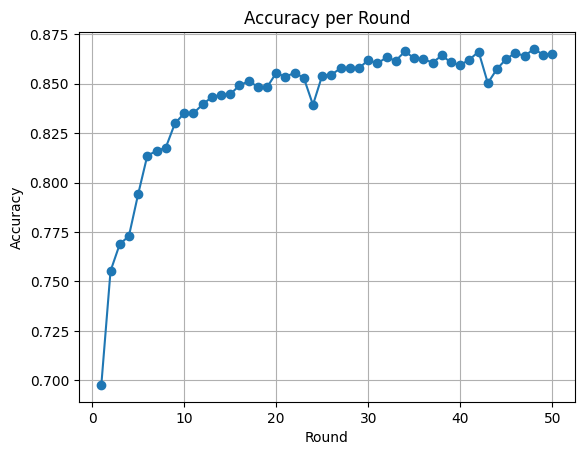

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1        NaN  0.716333       NaN       NaN       NaN  0.694667       NaN   
2        NaN  0.765667       NaN       NaN  0.752333  0.746667       NaN   
3   0.771000  0.765667  0.759667  0.771000  0.772667  0.746667  0.768000   
4   0.774000  0.765667  0.774333  0.771000  0.773333  0.746667  0.768000   
5   0.774000  0.765667  0.774333  0.771000  0.803667  0.746667  0.768000   
6   0.809000  0.822333  0.774333  0.771000  0.803667  0.746667  0.768000   
7   0.809000  0.822333  0.774333  0.815667  0.803667  0.746667  0.768000   
8   0.809000  0.822333  0.774333  0.815667  0.803667  0.746667  0.768000   
9   0.829333  0.838333  0.774333  0.815667  0.803667  0.834000  0.768000   
10  0.829333  0.839667  0.774333  0.815667  0.803667  0.836333  0.768000   
11  0.829333  0.839667  0.774333  0.815667  0.843667  0.836333  0.768000   
12  0.829333  0.839667  0.843000  0.815667  0.843667  0.

In [ ]:
fashion_mnist_iid_strategy_C = MethodC(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), fashion_mnist_dataloader.test_loader))

start_simulation(fashion_mnist_train_iid_loaders, fashion_mnist_test_iid_loaders, fashion_mnist_iid_strategy_C)
fashion_mnist_iid_strategy_C.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/iid_strategy_C_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
fashion_mnist_iid_strategy_C.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/iid_strategy_C_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### Fashion MNIST - Method C - non iid data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-22 07:50:47,490	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 8043938612.0, 'object_store_memory': 4021969305.0}
INFO :      Optimize your simulation with Flower VCE: https://flow

server_round: 1
Serial number of the client selected to fit: ['13', '16', '0', '1', '10', '12', '4', '2', '15', '6']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 4271.098680615425, {'accuracy': 0.18131666666666665}, 31.7154276509973)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['13', '16', '0', '1', '10', '12', '4', '2', '15', '6']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


server_round: 2
server_round: 2
Serial number of the client selected to fit: ['0', '1', '6', '7', '8', '11', '12', '13', '14', '18', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (2, 3601.9927495718002, {'accuracy': 0.26918333333333333}, 73.05278965999969)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '6', '7', '8', '11', '12', '13', '14', '18', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


server_round: 3
server_round: 3
Serial number of the client selected to fit: ['0', '1', '2', '4', '5', '7', '9', '11', '16', '17', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (3, 2920.394696712494, {'accuracy': 0.4239}, 112.51861714599727)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '5', '7', '9', '11', '16', '17', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 4
server_round: 4
Serial number of the client selected to fit: ['2', '5', '6', '8', '10', '11', '12', '13', '15', '17']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 2369.242272078991, {'accuracy': 0.5042166666666666}, 152.64056537500073)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '5', '6', '8', '10', '11', '12', '13', '15', '17']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 5
server_round: 5
Serial number of the client selected to fit: ['0', '1', '2', '5', '7', '9', '11', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (5, 2658.0593845248222, {'accuracy': 0.5015}, 194.07773867499782)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '5', '7', '9', '11', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 6
server_round: 6
Serial number of the client selected to fit: ['0', '3', '4', '5', '8', '9', '10', '13', '17']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (6, 2679.610874950886, {'accuracy': 0.5065166666666666}, 233.59063224299825)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '4', '5', '8', '9', '10', '13', '17']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 7
server_round: 7
Serial number of the client selected to fit: ['0', '2', '3', '4', '5', '6', '8', '9', '11', '13', '14', '18']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (7, 2620.7831077575684, {'accuracy': 0.49383333333333335}, 274.0218537449982)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '5', '6', '8', '9', '11', '13', '14', '18']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 8
server_round: 8
Serial number of the client selected to fit: ['0', '3', '5', '8', '11', '13', '14']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (8, 2515.498057246208, {'accuracy': 0.5205833333333333}, 309.72631711699796)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '5', '8', '11', '13', '14']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 9
server_round: 9
Serial number of the client selected to fit: ['0', '1', '2', '3', '6', '8', '9', '13', '14', '15']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (9, 2349.4966700673103, {'accuracy': 0.5767666666666666}, 345.04183677900073)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '6', '8', '9', '13', '14', '15']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 10
server_round: 10
Serial number of the client selected to fit: ['0', '1', '3', '7', '8', '11', '13', '15', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (10, 2036.92889803648, {'accuracy': 0.6242666666666666}, 380.63283369499914)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '7', '8', '11', '13', '15', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 11
server_round: 11
Serial number of the client selected to fit: ['4', '5', '8', '10', '11', '13', '15']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (11, 1700.4065791070461, {'accuracy': 0.66675}, 413.7364913229976)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '5', '8', '10', '11', '13', '15']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 12
server_round: 12
Serial number of the client selected to fit: ['3', '4', '9', '12', '15', '16', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (12, 1614.0641858577728, {'accuracy': 0.64865}, 443.06158048499856)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '4', '9', '12', '15', '16', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 13
server_round: 13
Serial number of the client selected to fit: ['0', '4', '9', '15', '16']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (13, 2012.1994353830814, {'accuracy': 0.5987}, 470.7130874729992)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '9', '15', '16']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 14
server_round: 14
Serial number of the client selected to fit: ['2', '4', '5', '7', '8', '15']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (14, 1898.367135643959, {'accuracy': 0.6093666666666666}, 497.31620633000057)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '5', '7', '8', '15']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 15
server_round: 15
Serial number of the client selected to fit: ['1', '2', '5', '11', '15', '17']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (15, 2030.4040151834488, {'accuracy': 0.5776833333333333}, 523.9770860889985)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '11', '15', '17']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 16
server_round: 16
Serial number of the client selected to fit: ['1', '2', '3', '7', '15', '17', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (16, 2119.0044333040714, {'accuracy': 0.6154333333333334}, 551.8592996189982)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '7', '15', '17', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 17
server_round: 17
Serial number of the client selected to fit: ['2', '3', '5', '7', '9', '10', '11', '14', '16']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (17, 1957.2994776666164, {'accuracy': 0.5946166666666667}, 585.167526276)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '5', '7', '9', '10', '11', '14', '16']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 18
server_round: 18
Serial number of the client selected to fit: ['4', '7', '8', '9', '10', '16', '17', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (18, 1530.5648069381714, {'accuracy': 0.7065666666666667}, 621.9912992779973)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '7', '8', '9', '10', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 19
server_round: 19
Serial number of the client selected to fit: ['3', '14', '16']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (19, 2330.305805981159, {'accuracy': 0.58485}, 648.5373274759986)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '14', '16']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 20
server_round: 20
Serial number of the client selected to fit: ['7', '8', '9', '10', '12', '15', '16', '17']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (20, 1704.9979119598866, {'accuracy': 0.6517333333333334}, 675.2980326910001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '8', '9', '10', '12', '15', '16', '17']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 21
server_round: 21
Serial number of the client selected to fit: ['2', '4', '8', '11', '14', '17']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (21, 1577.8175499737263, {'accuracy': 0.68645}, 705.9594624519996)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '8', '11', '14', '17']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 22
server_round: 22
Serial number of the client selected to fit: ['1', '2', '3', '8', '12', '15', '17', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (22, 1749.0763103663921, {'accuracy': 0.6780833333333334}, 736.1598164619973)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '8', '12', '15', '17', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 23
server_round: 23
Serial number of the client selected to fit: ['2', '6', '8', '9', '11', '13', '17', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (23, 1514.4458737373352, {'accuracy': 0.6817166666666666}, 768.500671714999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '6', '8', '9', '11', '13', '17', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 24
server_round: 24
Serial number of the client selected to fit: ['4', '6', '7', '8', '12', '15']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (24, 1955.7621061205864, {'accuracy': 0.6295166666666666}, 799.0406740590006)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '6', '7', '8', '12', '15']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 25
server_round: 25
Serial number of the client selected to fit: ['0', '4', '8', '10', '15', '17']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (25, 1648.7004152834415, {'accuracy': 0.67115}, 828.5409382819998)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '8', '10', '15', '17']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 26
server_round: 26
Serial number of the client selected to fit: ['1', '2', '5', '9', '12', '13', '14', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (26, 1757.3933915495872, {'accuracy': 0.6598}, 862.8944149279996)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '9', '12', '13', '14', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 27
server_round: 27
Serial number of the client selected to fit: ['10', '16', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (27, 1953.0158484876156, {'accuracy': 0.6155166666666667}, 890.6864307680007)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['10', '16', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 28
server_round: 28
Serial number of the client selected to fit: ['4', '6', '17', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 2424.454297989607, {'accuracy': 0.5703}, 911.9809253499989)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '6', '17', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 29
server_round: 29
Serial number of the client selected to fit: ['1', '2', '5', '13', '15', '16', '17', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (29, 1839.4231221675873, {'accuracy': 0.671}, 941.2706223299974)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '13', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 30
server_round: 30
Serial number of the client selected to fit: ['7', '8', '17', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (30, 1797.345964282751, {'accuracy': 0.6696833333333333}, 969.4551716799979)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '8', '17', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 31
server_round: 31
Serial number of the client selected to fit: ['3', '6', '7', '8', '11', '12', '16']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (31, 1374.1576232612133, {'accuracy': 0.7069166666666666}, 996.0295958120005)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '6', '7', '8', '11', '12', '16']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 32
server_round: 32
Serial number of the client selected to fit: ['2', '11', '14']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (32, 2007.1158908307552, {'accuracy': 0.6172166666666666}, 1022.3238401559975)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '11', '14']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 33
server_round: 33
Serial number of the client selected to fit: ['2', '8', '9', '11', '13', '14', '15', '16']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (33, 1253.4678332060575, {'accuracy': 0.7540666666666667}, 1051.439041401998)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '8', '9', '11', '13', '14', '15', '16']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 34
server_round: 34
Serial number of the client selected to fit: ['2', '9', '13', '15', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (34, 1708.7513082623482, {'accuracy': 0.6388833333333334}, 1081.1434297099986)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '9', '13', '15', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 35
server_round: 35
Serial number of the client selected to fit: ['0', '8', '11', '14', '15', '16', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (35, 1316.535768225789, {'accuracy': 0.7423}, 1109.2264567059974)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '8', '11', '14', '15', '16', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 36
server_round: 36
Serial number of the client selected to fit: ['6', '8', '13', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (36, 2101.1401159465313, {'accuracy': 0.66125}, 1135.7441982950004)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '8', '13', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 37
server_round: 37
Serial number of the client selected to fit: ['0', '1', '3', '4', '5', '9', '15']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (37, 1918.560604006052, {'accuracy': 0.6563}, 1164.0000293140001)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '4', '5', '9', '15']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 38
server_round: 38
Serial number of the client selected to fit: ['5', '6', '11']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (38, 1905.0908139944077, {'accuracy': 0.6081166666666666}, 1190.536073733998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '6', '11']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 39
server_round: 39
Serial number of the client selected to fit: ['1', '3', '6', '9', '10', '13', '18', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (39, 1770.5046173036098, {'accuracy': 0.6562666666666667}, 1217.0790848409997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '6', '9', '10', '13', '18', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 40
server_round: 40
Serial number of the client selected to fit: ['2', '4', '5', '6', '15', '16', '17', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (40, 1387.0840694010258, {'accuracy': 0.7145}, 1251.0464456789996)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '5', '6', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 41
server_round: 41
Serial number of the client selected to fit: ['2', '5', '9', '12', '14', '17', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (41, 1907.473922342062, {'accuracy': 0.6623333333333333}, 1283.7511802339977)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '5', '9', '12', '14', '17', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 42
server_round: 42
Serial number of the client selected to fit: ['8', '12', '16']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (42, 1359.5008331686258, {'accuracy': 0.75035}, 1309.2550379579989)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '12', '16']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 43
server_round: 43
Serial number of the client selected to fit: ['1', '4', '18', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (43, 1898.0848768502474, {'accuracy': 0.6682666666666667}, 1332.8594733009995)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '18', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 44
server_round: 44
Serial number of the client selected to fit: ['0', '3', '4', '11', '13', '17', '18', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (44, 1221.3280624747276, {'accuracy': 0.76475}, 1360.3013195530002)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '4', '11', '13', '17', '18', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 45
server_round: 45
Serial number of the client selected to fit: ['5', '6', '8', '12', '18']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (45, 1482.5677596628666, {'accuracy': 0.7285166666666667}, 1390.2762267199978)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '6', '8', '12', '18']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 46
server_round: 46
Serial number of the client selected to fit: ['1', '2', '11', '13', '14']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (46, 1356.2255378812551, {'accuracy': 0.7225833333333334}, 1418.0531069019999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '11', '13', '14']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 47
server_round: 47
Serial number of the client selected to fit: ['1', '6', '7', '8', '9', '16']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (47, 1500.2732208669186, {'accuracy': 0.7184166666666667}, 1447.621538135998)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '6', '7', '8', '9', '16']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 48
server_round: 48
Serial number of the client selected to fit: ['8', '11', '17', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (48, 1295.059611827135, {'accuracy': 0.7534666666666666}, 1473.7937714359978)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '11', '17', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 49
server_round: 49
Serial number of the client selected to fit: ['2', '9', '13', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (49, 1666.1023726910353, {'accuracy': 0.66475}, 1498.7428008049974)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '9', '13', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 50
server_round: 50
Serial number of the client selected to fit: ['3', '5', '6', '8', '9', '10', '12', '14', '17']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (50, 1511.0872131586075, {'accuracy': 0.7377833333333333}, 1530.2521225279997)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '5', '6', '8', '9', '10', '12', '14', '17']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 1541.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 48.35147355794906
INFO :      		round 2: 32.56556656143882
INFO :      		round 3: 28.595549697225746
INFO :      		round 4: 28.085539811849593
INFO :      		round 5: 23.635102354563198
INFO :      		round 6: 23.29969169033898
INFO :      		round 7: 23.663066717485588
INFO :      		round 8: 17.964859119483403
INFO :      		round 9: 18.412576714158057
INFO :      		round 10: 17.35891624622875
INFO :      		round 11: 19.771339116351946
INFO :      		round 12: 15.988193109631538
INFO :      		round 13: 19.40244592130184
INFO :      		round 14: 16.96741660187642
INFO :      		round 15: 20.37228001157443
INFO :      		round 16: 18.060851284435817
INFO :      		round 17: 17.371000156634384
INFO :      		round 18: 15.869389462802145
INFO :      		round 19: 12.353246693809828
INFO : 

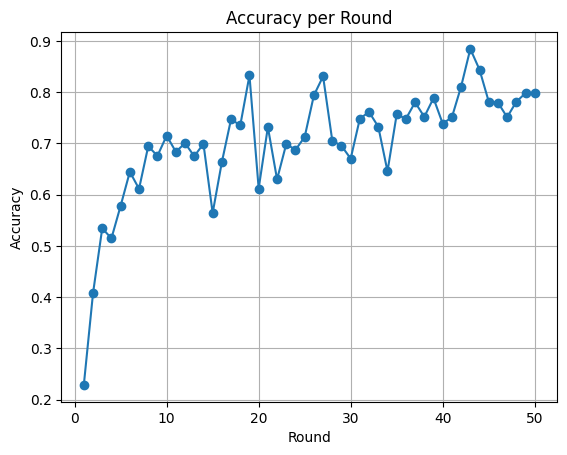

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.212264  0.166372  0.402762       NaN  0.256198       NaN  0.319172   
2   0.757075  0.127434  0.402762       NaN  0.256198       NaN  0.538126   
3   0.636792  0.573451  0.523590       NaN  0.631641  0.878728  0.538126   
4   0.636792  0.573451  0.319908       NaN  0.631641  0.572565  0.550109   
5   0.804245  0.692035  0.594937       NaN  0.631641  0.785288  0.550109   
6   0.655660  0.692035  0.594937  0.676647  0.711924  0.767396  0.550109   
7   0.875000  0.692035  0.706559  0.739521  0.587957  0.516899  0.745098   
8   0.778302  0.692035  0.706559  0.788922  0.587957  0.880716  0.745098   
9   0.870283  0.646018  0.630610  0.790419  0.587957  0.880716  0.702614   
10  0.839623  0.865487  0.630610  0.809880  0.587957  0.880716  0.702614   
11  0.839623  0.865487  0.630610  0.809880  0.879575  0.848907  0.702614   
12  0.839623  0.865487  0.630610  0.808383  0.874852  0.

In [ ]:
fashion_mnist_non_iid_strategy_C = MethodC(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), fashion_mnist_dataloader.test_loader))

start_simulation(fashion_mnist_train_non_iid_loaders, fashion_mnist_test_non_iid_loaders, fashion_mnist_non_iid_strategy_C)
fashion_mnist_non_iid_strategy_C.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/non_iid_strategy_C_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
fashion_mnist_non_iid_strategy_C.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/non_iid_strategy_C_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### Fashion MNIST - Method D - iid data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout


Initial p1 values:
Client 1: 0.8827165664031702
Client 2: 0.6069164956514413
Client 3: 0.8803767250974235
Client 4: 0.9264941521750448
Client 5: 0.03882357024911198
Client 6: 0.8665231159000643
Client 7: 0.8439611358855263
Client 8: 0.25293656366387407
Client 9: 0.018659116806650555
Client 10: 0.5109314023815072
Client 11: 0.3555683025051686
Client 12: 0.3759667410816355
Client 13: 0.11022973487136067
Client 14: 0.7788652515266101
Client 15: 0.025968420271582082
Client 16: 0.5259356471023748
Client 17: 0.08830007590507516
Client 18: 0.2506439778635553
Client 19: 0.6561533286575929
Client 20: 0.5671340957627784

Initial p2 values:
Client 1: 0.21658103819475227
Client 2: 0.14314070377025734
Client 3: 0.43594555617443065
Client 4: 0.16369947192002243
Client 5: 0.6074887926246365
Client 6: 0.8364534294288198
Client 7: 0.4837101812090562
Client 8: 0.8541907609470206
Client 9: 0.7102831703230048
Client 10: 0.7020250306896648
Client 11: 0.8750160184615413
Client 12: 0.7395930224480698
Client 

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-22 08:17:02,708	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 8043965646.0, 'object_store_memory': 4021982822.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=79364) 2024-07-22 08:17:10.146567: E external/l

Serial number of the client selected to fit: ['14', '15', '17']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 1790.4120925068855, {'accuracy': 0.6746}, 26.37157121999917)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['14', '15', '17']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '4', '7', '8', '11', '15', '16', '18']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (2, 1298.7397514730692, {'accuracy': 0.7433333333333333}, 66.72921588199824)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '4', '7', '8', '11', '15', '16', '18']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['9', '11', '12']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 1287.0825293958187, {'accuracy': 0.7447166666666667}, 101.73873381700105)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['9', '11', '12']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['4', '7', '10', '12', '14', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (4, 1152.3064807653427, {'accuracy': 0.76745}, 134.99183944000106)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '7', '10', '12', '14', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['1', '5', '7', '10', '14', '17']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (5, 1089.492019891739, {'accuracy': 0.7805333333333333}, 174.7274156530002)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '7', '10', '14', '17']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['8', '11', '12', '16', '18', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (6, 1040.3513080328703, {'accuracy': 0.7912833333333333}, 211.80299804099923)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '11', '12', '16', '18', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['5', '6', '9', '10', '12']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 1023.3691798895597, {'accuracy': 0.7947}, 248.24595463600053)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '6', '9', '10', '12']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['3', '14', '19']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (8, 989.064563639462, {'accuracy': 0.80845}, 277.3954288809982)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '14', '19']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['8', '10', '16', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 958.5173002183437, {'accuracy': 0.8153166666666667}, 306.52524098399954)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '10', '16', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '10', '12', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 938.6356903612614, {'accuracy': 0.82295}, 336.608287695999)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '10', '12', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '7', '10', '14']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 947.7157297804952, {'accuracy': 0.8237333333333333}, 366.961110111999)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '7', '10', '14']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['1', '14']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (12, 971.2054059505463, {'accuracy': 0.8244}, 393.0769475640009)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '14']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['0', '4', '12', '13', '15']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (13, 898.7993109002709, {'accuracy': 0.8324333333333334}, 421.50260016899847)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '12', '13', '15']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['14']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (14, 1062.2542998716235, {'accuracy': 0.8189}, 447.1618709360009)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['14']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['6', '8', '9', '15']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 902.4149741530418, {'accuracy': 0.8343166666666667}, 475.04149127799974)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '8', '9', '15']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['10', '12', '14', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 911.1376057937741, {'accuracy': 0.8385}, 504.9466789340004)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['10', '12', '14', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['11', '12']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (17, 1008.5222124680877, {'accuracy': 0.8167833333333333}, 529.9748530920006)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['11', '12']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['12', '19']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (18, 992.8124458864331, {'accuracy': 0.8326666666666667}, 553.3791864310006)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['12', '19']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['11', '13', '14', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 954.1394622400403, {'accuracy': 0.8366166666666667}, 579.5814043600003)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['11', '13', '14', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['2', '8', '9', '14', '16', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (20, 910.2483479678631, {'accuracy': 0.843}, 615.0868826879996)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '8', '9', '14', '16', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['2']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (21, 1056.6918270289898, {'accuracy': 0.8162}, 642.4477623969979)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['2']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['8']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (22, 983.8082354366779, {'accuracy': 0.8239}, 661.1514540700009)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['8']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['8', '10', '15']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (23, 921.1736226007342, {'accuracy': 0.8381666666666666}, 686.2631753309979)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '10', '15']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '9', '18', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 900.5914298258722, {'accuracy': 0.84885}, 716.9710269409989)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '9', '18', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['6', '11', '12']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 886.6583774089813, {'accuracy': 0.8512333333333333}, 744.2022076969988)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '11', '12']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['0', '8', '12', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (26, 912.5495706126094, {'accuracy': 0.8485}, 772.7168526450005)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '8', '12', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['11', '14']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (27, 998.4202294461429, {'accuracy': 0.84315}, 799.3164956110013)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['11', '14']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['16']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (28, 1082.2935448661447, {'accuracy': 0.8294833333333334}, 818.9516249669978)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['16']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['9', '10', '16']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (29, 976.2088783271611, {'accuracy': 0.8438833333333333}, 844.3839994339978)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['9', '10', '16']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['16']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (30, 1166.930352523923, {'accuracy': 0.8385333333333334}, 865.2288970919981)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['16']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['12']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (31, 1125.153907738626, {'accuracy': 0.8326833333333333}, 883.5563280569986)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['12']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['4', '8', '14', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (32, 946.2812938950956, {'accuracy': 0.8464}, 909.9936349550007)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '8', '14', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['9', '13', '14', '17', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (33, 921.3252153135836, {'accuracy': 0.8509166666666667}, 942.7783304069999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['9', '13', '14', '17', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['8', '15']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (34, 986.3104206584394, {'accuracy': 0.84505}, 969.5602766429984)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '15']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '9', '13', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (35, 967.5603382699192, {'accuracy': 0.8553833333333334}, 994.9487546339988)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '9', '13', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['8', '11']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (36, 988.1964733563364, {'accuracy': 0.8517166666666667}, 1020.8706426479985)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '11']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['7', '11']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (37, 1027.256047738716, {'accuracy': 0.8482666666666666}, 1041.621838007999)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '11']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['4', '7', '11', '12', '15']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (38, 957.247968653217, {'accuracy': 0.8540833333333333}, 1071.590071849001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '7', '11', '12', '15']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '8', '18', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (39, 957.3622123114765, {'accuracy': 0.8548666666666667}, 1102.6432915900004)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '8', '18', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '7', '15', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (40, 919.1549050491303, {'accuracy': 0.8572}, 1135.2535199249978)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '7', '15', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['17']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (41, 1112.996316689998, {'accuracy': 0.8353}, 1160.2830429829992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['17']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['1', '7', '8']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (42, 963.268131878227, {'accuracy': 0.85445}, 1183.0854072340007)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '7', '8']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '8', '10']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (43, 954.7088586371392, {'accuracy': 0.8583333333333333}, 1213.0053094319992)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '8', '10']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['2', '6', '14', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (44, 967.6935075661168, {'accuracy': 0.8576333333333334}, 1243.992815190999)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '6', '14', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['19']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (45, 1173.1249116715044, {'accuracy': 0.8416666666666667}, 1266.4627519649985)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['19']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['2', '7', '13', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (46, 970.3017722032964, {'accuracy': 0.8557833333333333}, 1293.664356344998)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '7', '13', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['8']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (47, 1136.197620227933, {'accuracy': 0.8374833333333334}, 1315.7449995200004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['8']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['7']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (48, 1134.2600373383611, {'accuracy': 0.8381}, 1334.4348915509981)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['7']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['5', '14']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (49, 1028.8682558927685, {'accuracy': 0.8510833333333333}, 1355.6408973899997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '14']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['7', '10']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (50, 1020.0611524619162, {'accuracy': 0.8537666666666667}, 1376.8183376230008)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '10']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 1380.00s
INFO :      	History (loss, distributed):
INFO :      		round 1: 90.31048669417699
INFO :      		round 2: 64.92196625719468
INFO :      		round 3: 64.7529188649108
INFO :      		round 4: 57.09377484171031
INFO :      		round 5: 54.59081179472074
INFO :      		round 6: 52.24443882688259
INFO :      		round 7: 51.531232205661944
INFO :      		round 8: 49.299683384907745
INFO :      		round 9: 48.71799624152118
INFO :      		round 10: 46.6736802595733
INFO :      		round 11: 47.29582228063009
INFO :      		round 12: 46.08502833315288
INFO :      		round 13: 43.9043353783898
INFO :      		round 14: 52.71654564817436
INFO :      		round 15: 45.632190729666036
INFO :      		round 16: 45.736771737511845
INFO :      		round 17: 49.626697056984995
INFO :      		round 18: 48.64003165642498
INFO :      		round 19: 47.00453609233955
INFO :      		rou

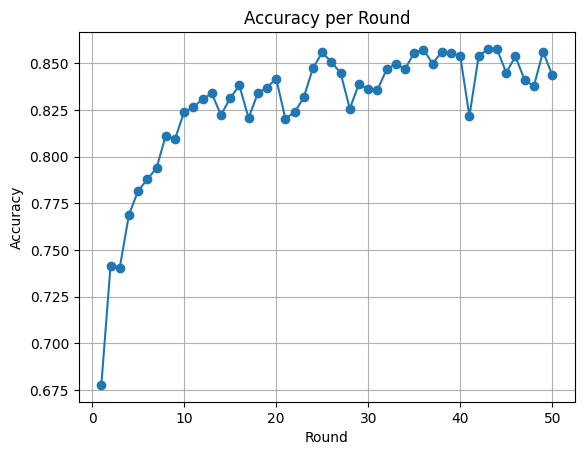

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2        NaN  0.746000  0.740000       NaN  0.744333       NaN       NaN   
3        NaN  0.746000  0.740000       NaN  0.744333       NaN       NaN   
4        NaN  0.746000  0.740000       NaN  0.779000       NaN       NaN   
5        NaN  0.786333  0.740000       NaN  0.779000  0.777333       NaN   
6        NaN  0.786333  0.740000       NaN  0.779000  0.777333       NaN   
7        NaN  0.786333  0.740000       NaN  0.779000  0.799000  0.799667   
8        NaN  0.786333  0.740000  0.807667  0.779000  0.799000  0.799667   
9        NaN  0.786333  0.740000  0.807667  0.779000  0.799000  0.799667   
10       NaN  0.833000  0.740000  0.807667  0.779000  0.799000  0.799667   
11       NaN  0.834000  0.740000  0.807667  0.779000  0.799000  0.799667   
12       NaN  0.831667  0.740000  0.807667  0.779000  0.

In [ ]:
fashion_mnist_iid_strategy_D = MethodD(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), fashion_mnist_dataloader.test_loader))

start_simulation(fashion_mnist_train_iid_loaders, fashion_mnist_test_iid_loaders, fashion_mnist_iid_strategy_D)
fashion_mnist_iid_strategy_D.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/iid_strategy_D_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
fashion_mnist_iid_strategy_D.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/iid_strategy_D_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
fashion_mnist_iid_strategy_D.availability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/iid_strategy_D_availability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')


### Fashion MNIST - Method D - non iid data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout


Initial p1 values:
Client 1: 0.5386850471300451
Client 2: 0.3002284690961462
Client 3: 0.2534754975869772
Client 4: 0.7974990903524345
Client 5: 0.2433454674405945
Client 6: 0.9967368747865478
Client 7: 0.339635673872703
Client 8: 0.3154566260099715
Client 9: 0.9074623816427714
Client 10: 0.777724962083763
Client 11: 0.9804024402409516
Client 12: 0.6267501120151173
Client 13: 0.07174869681272433
Client 14: 0.21807234092393746
Client 15: 0.6703697198624928
Client 16: 0.3753179557430135
Client 17: 0.4638029302396284
Client 18: 0.2977257629906257
Client 19: 0.387146355566921
Client 20: 0.7425450950747404

Initial p2 values:
Client 1: 0.554141895095856
Client 2: 0.38929930622169395
Client 3: 0.6437729242965315
Client 4: 0.22288931930281686
Client 5: 0.5503931394148165
Client 6: 0.8749035502171846
Client 7: 0.1412835049461636
Client 8: 0.4395576625056766
Client 9: 0.6314133112562461
Client 10: 0.6692024149681866
Client 11: 0.9487409469313494
Client 12: 0.2982948113607794
Client 13: 0.839785

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-22 08:40:40,223	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 8043046503.0, 'object_store_memory': 4021523251.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=85698) 2024-07-22 08:40:45.283579: E external/l

Serial number of the client selected to fit: ['1', '2', '4', '15']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 4623.105667233467, {'accuracy': 0.14518333333333333}, 22.85936720400059)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '4', '15']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '4', '8', '9', '10', '13', '17']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (2, 3660.380312681198, {'accuracy': 0.38785}, 53.00380036500064)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '8', '9', '10', '13', '17']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['3', '12']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (3, 4313.203698158264, {'accuracy': 0.19885}, 78.90509369700158)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '12']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['8', '9', '10', '12']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 2874.06172144413, {'accuracy': 0.39468333333333333}, 100.39314911500333)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '9', '10', '12']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['4', '9', '17', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 3192.519626379013, {'accuracy': 0.4289}, 123.91192131800199)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '9', '17', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['2', '10', '17']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 2955.2829164266586, {'accuracy': 0.4608333333333333}, 147.08112011200137)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '10', '17']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['11', '12', '17']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 3535.332317173481, {'accuracy': 0.4103833333333333}, 167.6595409670008)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['11', '12', '17']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['5', '7', '8', '10', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 4010.35084939003, {'accuracy': 0.40463333333333334}, 192.69171805000224)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '7', '8', '10', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['0', '7', '9', '18', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (9, 2890.850876033306, {'accuracy': 0.5107666666666667}, 218.74305710400222)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '7', '9', '18', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['7', '8', '9', '17']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 2853.801135659218, {'accuracy': 0.47833333333333333}, 243.43876163400273)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '8', '9', '17']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['4', '7']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (11, 3120.434176027775, {'accuracy': 0.5398833333333334}, 264.8135620760004)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '7']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['1', '9']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (12, 3189.992459177971, {'accuracy': 0.4345833333333333}, 284.50080363600136)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '9']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['2', '13', '17', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 2584.78640550375, {'accuracy': 0.47046666666666664}, 305.0643105270028)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '13', '17', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '6', '12', '15', '18', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (14, 2444.2365902662277, {'accuracy': 0.5415166666666666}, 333.179042486001)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '6', '12', '15', '18', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['7']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (15, 3463.409823536873, {'accuracy': 0.4871333333333333}, 355.1082430380011)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['7']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['4', '5', '8', '9', '12']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (16, 2953.3755556344986, {'accuracy': 0.4642}, 376.66547997400266)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '5', '8', '9', '12']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '7', '12', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (17, 2166.8432894945145, {'accuracy': 0.5734666666666667}, 402.4490872740025)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '7', '12', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['7', '17']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (18, 1794.4817412495613, {'accuracy': 0.6286333333333334}, 424.1978414360019)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '17']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['11']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (19, 4472.12889611721, {'accuracy': 0.34695}, 442.07967832600116)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['11']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['10', '12']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (20, 2808.489895403385, {'accuracy': 0.46563333333333334}, 460.1179557930009)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['10', '12']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '7', '8']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 2154.8250256180763, {'accuracy': 0.5517333333333333}, 481.02642238200133)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '7', '8']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['5', '7', '9', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 3068.4733203053474, {'accuracy': 0.4678333333333333}, 505.67914594000104)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '7', '9', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['12']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (23, 2723.112626194954, {'accuracy': 0.45965}, 525.8625085370004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['12']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['2', '8', '9', '11', '14']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (24, 1758.150293380022, {'accuracy': 0.65615}, 547.0372435860008)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '8', '9', '11', '14']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '10', '13']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (25, 2117.2152765393257, {'accuracy': 0.6055166666666667}, 572.6091915850011)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '10', '13']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['1', '12']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (26, 2930.7390308976173, {'accuracy': 0.5515666666666666}, 593.2134356840033)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '12']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['10', '17', '19']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (27, 1984.8171524107456, {'accuracy': 0.60765}, 613.2325047880004)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['10', '17', '19']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '6', '9', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (28, 1965.9869045615196, {'accuracy': 0.62105}, 638.1377039640029)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '6', '9', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['6', '9', '12', '17']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 1970.5344141721725, {'accuracy': 0.6208333333333333}, 663.229788820001)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '9', '12', '17']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '6', '8', '10', '11', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (30, 1567.4863022565842, {'accuracy': 0.6978333333333333}, 690.8725987070029)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '6', '8', '10', '11', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '4', '7', '17', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (31, 1591.4352460503578, {'accuracy': 0.66625}, 721.7333961310032)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '4', '7', '17', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['10', '12', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (32, 1535.4807837307453, {'accuracy': 0.6977}, 747.5392350670008)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['10', '12', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['17']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (33, 2549.097939580679, {'accuracy': 0.6592666666666667}, 768.4051778530011)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['17']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['8']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (34, 2511.0334172546864, {'accuracy': 0.6291}, 784.2495318690017)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['8']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '5', '6', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (35, 1572.4061538279057, {'accuracy': 0.6801333333333334}, 805.884033483002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '6', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['6', '12']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (36, 2226.56353315711, {'accuracy': 0.6305333333333333}, 828.4837318490027)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '12']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['12', '17', '19']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (37, 1684.3062736690044, {'accuracy': 0.6951833333333334}, 847.8995842850018)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['12', '17', '19']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['12']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (38, 1661.3834345340729, {'accuracy': 0.6884666666666667}, 865.5430449850028)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['12']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '8', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (39, 1842.9463975727558, {'accuracy': 0.6873333333333334}, 888.1444045020035)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '8', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '5', '12', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (40, 2057.4616326987743, {'accuracy': 0.6528166666666667}, 911.4111736550003)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '12', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '19']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (41, 2238.5755118131638, {'accuracy': 0.6285666666666667}, 933.3101333160012)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '19']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['19']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (42, 3104.11487698555, {'accuracy': 0.5426166666666666}, 951.9766619080001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['19']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['3', '10', '11']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (43, 1810.193088054657, {'accuracy': 0.6062666666666666}, 970.0856957100004)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '10', '11']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['2', '19']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (44, 2886.9678149223328, {'accuracy': 0.5433333333333333}, 988.985657098001)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '19']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['2', '10', '12']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (45, 1963.7631687819958, {'accuracy': 0.6387166666666667}, 1008.1040685280022)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '10', '12']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['12']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (46, 1707.6951844990253, {'accuracy': 0.6942333333333334}, 1025.8025347170005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['12']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '8', '16']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (47, 1526.7437223941088, {'accuracy': 0.7030333333333333}, 1048.0226202520025)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '8', '16']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['9', '12']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (48, 3018.8013684749603, {'accuracy': 0.5058666666666667}, 1068.9280865040018)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['9', '12']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['8', '11']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (49, 1583.0800353884697, {'accuracy': 0.7047666666666667}, 1086.648362930002)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '11']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '7']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (50, 2066.984813451767, {'accuracy': 0.6443333333333333}, 1106.7554984160015)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '7']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 1111.15s
INFO :      	History (loss, distributed):
INFO :      		round 1: 40.73716405034065
INFO :      		round 2: 37.083897195756435
INFO :      		round 3: 29.694641947746277
INFO :      		round 4: 28.29344914853573
INFO :      		round 5: 23.025775358080864
INFO :      		round 6: 35.05484185616175
INFO :      		round 7: 18.890429536501568
INFO :      		round 8: 26.611165046691895
INFO :      		round 9: 14.611720556020737
INFO :      		round 10: 22.038269102573395
INFO :      		round 11: 12.029809035360813
INFO :      		round 12: 20.798485964536667
INFO :      		round 13: 21.205101490020752
INFO :      		round 14: 17.321791976690292
INFO :      		round 15: 5.83128197491169
INFO :      		round 16: 21.494403010583483
INFO :      		round 17: 11.769754757359625
INFO :      		round 18: 16.77569219470024
INFO :      		round 19: 13.929348707199097
INFO :

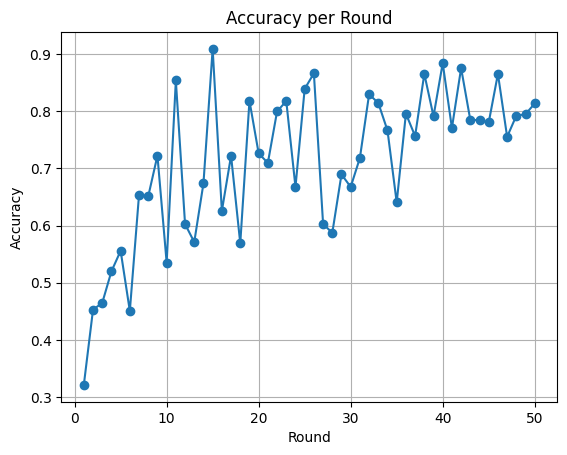

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1        NaN  0.584071  0.298044       NaN  0.142857       NaN       NaN   
2   0.856132  0.584071  0.408516       NaN  0.675325       NaN       NaN   
3   0.856132  0.584071  0.408516  0.185629  0.675325       NaN       NaN   
4   0.856132  0.584071  0.408516  0.185629  0.675325       NaN       NaN   
5   0.856132  0.584071  0.408516  0.185629  0.788666       NaN       NaN   
6   0.856132  0.584071  0.677791  0.185629  0.788666       NaN       NaN   
7   0.856132  0.584071  0.677791  0.185629  0.788666       NaN       NaN   
8   0.856132  0.584071  0.677791  0.185629  0.788666  0.813121       NaN   
9   0.886792  0.584071  0.677791  0.185629  0.788666  0.813121       NaN   
10  0.886792  0.584071  0.677791  0.185629  0.788666  0.813121       NaN   
11  0.886792  0.584071  0.677791  0.185629  0.852420  0.813121       NaN   
12  0.886792  0.681416  0.677791  0.185629  0.852420  0.

In [ ]:
fashion_mnist_non_iid_strategy_D = MethodD(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), fashion_mnist_dataloader.test_loader))

start_simulation(fashion_mnist_train_non_iid_loaders, fashion_mnist_test_non_iid_loaders, fashion_mnist_non_iid_strategy_D)
fashion_mnist_non_iid_strategy_D.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/non_iid_strategy_D_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
fashion_mnist_non_iid_strategy_D.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/non_iid_strategy_D_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
fashion_mnist_non_iid_strategy_D.availability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/fmnist/non_iid_strategy_D_availability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
